# Import Dataset

In [ ]:
pip install pandas numpy matplotlib seaborn scikit-learn catboost optuna

In [ ]:
pip install streamlit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import math
from scipy.stats import gaussian_kde
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from joblib import dump
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
import streamlit as st

In [ ]:
df = pd.read_csv('recruitment_data.csv')

# Stage 1

# Exploratory Data Analysis (EDA)

In [ ]:
df.head()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
0,26,1,2,0,3,26.783828,48,78,91,1,1
1,39,1,4,12,3,25.862694,35,68,80,2,1
2,48,0,2,3,2,9.920805,20,67,13,2,0
3,34,1,2,5,2,6.407751,36,27,70,3,0
4,30,0,1,6,1,43.105343,23,52,85,2,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  1500 non-null   int64  
 1   Gender               1500 non-null   int64  
 2   EducationLevel       1500 non-null   int64  
 3   ExperienceYears      1500 non-null   int64  
 4   PreviousCompanies    1500 non-null   int64  
 5   DistanceFromCompany  1500 non-null   float64
 6   InterviewScore       1500 non-null   int64  
 7   SkillScore           1500 non-null   int64  
 8   PersonalityScore     1500 non-null   int64  
 9   RecruitmentStrategy  1500 non-null   int64  
 10  HiringDecision       1500 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 129.0 KB


In [ ]:
df.describe()

,Age,Gender,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,RecruitmentStrategy,HiringDecision
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,35.148667,0.492000,2.188000,7.694000,3.00200,25.505379,50.564000,51.116000,49.387333,1.893333,0.310000
std,9.252728,0.500103,0.862449,4.641414,1.41067,14.567151,28.626215,29.353563,29.353201,0.689642,0.462647
min,20.000000,0.000000,1.000000,0.000000,1.00000,1.031376,0.000000,0.000000,0.000000,1.000000,0.000000
25%,27.000000,0.000000,2.000000,4.000000,2.00000,12.838851,25.000000,25.750000,23.000000,1.000000,0.000000
50%,35.000000,0.000000,2.000000,8.000000,3.00000,25.502239,52.000000,53.000000,49.000000,2.000000,0.000000
75%,43.000000,1.000000,3.000000,12.000000,4.00000,37.737996,75.000000,76.000000,76.000000,2.000000,1.000000
max,50.000000,1.000000,4.000000,15.000000,5.00000,50.992462,100.000000,100.000000,100.000000,3.000000,1.000000


In [ ]:
# cek missing value
df.isnull().sum()

,0
Age,0
Gender,0
EducationLevel,0
ExperienceYears,0
PreviousCompanies,0
DistanceFromCompany,0
InterviewScore,0
SkillScore,0
PersonalityScore,0
RecruitmentStrategy,0


In [ ]:
# cek spasi " "
mask = df.map(lambda x: isinstance(x, str) and " " in x)
df_spaces_only = df.where(mask).dropna(how="all")   # drop baris yang kosong semua
print(df_spaces_only)

Empty DataFrame
Columns: [Age, Gender, EducationLevel, ExperienceYears, PreviousCompanies, DistanceFromCompany, InterviewScore, SkillScore, PersonalityScore, RecruitmentStrategy, HiringDecision]
Index: []


In [ ]:
# cek duplicates
duplicates = df[df.duplicated()]
print("Baris duplikat:", duplicates)

Baris duplikat: Empty DataFrame
Columns: [Age, Gender, EducationLevel, ExperienceYears, PreviousCompanies, DistanceFromCompany, InterviewScore, SkillScore, PersonalityScore, RecruitmentStrategy, HiringDecision]
Index: []


Outliers per kolom:
Age: 0
Gender: 0
EducationLevel: 0
ExperienceYears: 0
PreviousCompanies: 0
DistanceFromCompany: 0
InterviewScore: 0
SkillScore: 0
PersonalityScore: 0
RecruitmentStrategy: 0
HiringDecision: 0


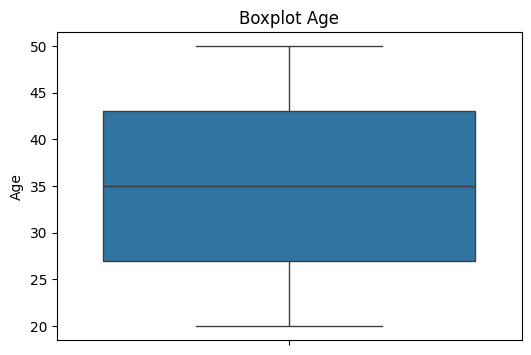

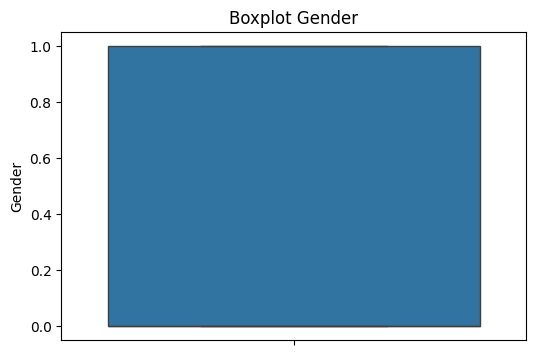

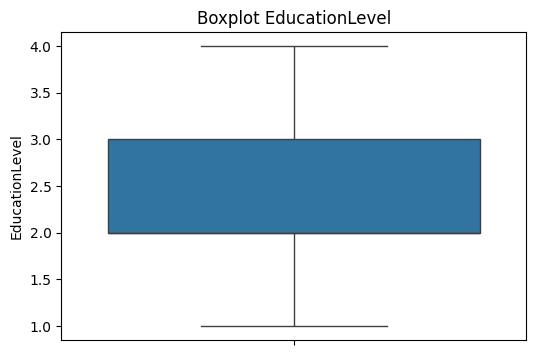

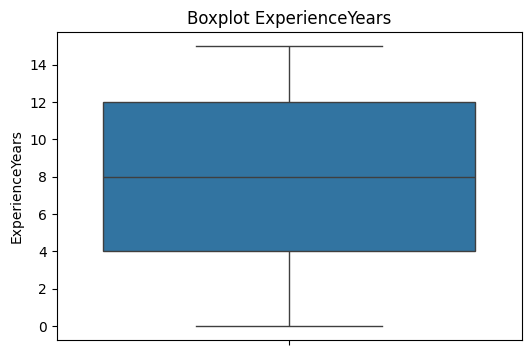

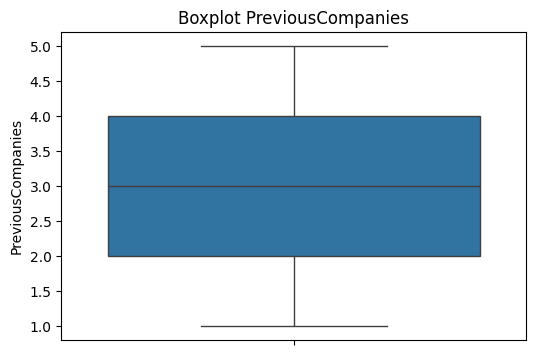

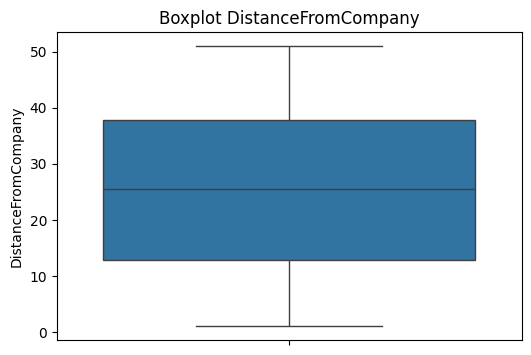

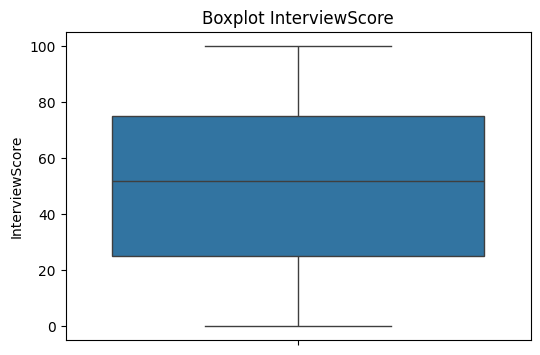

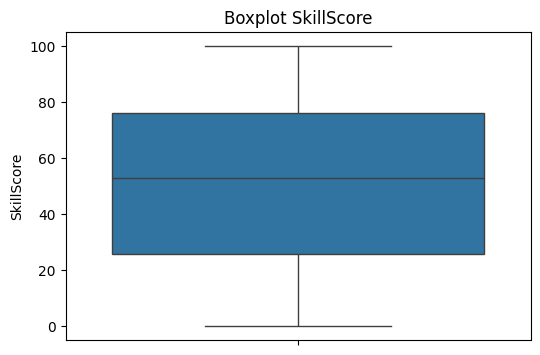

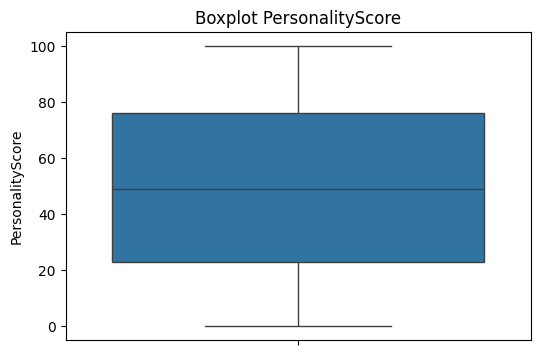

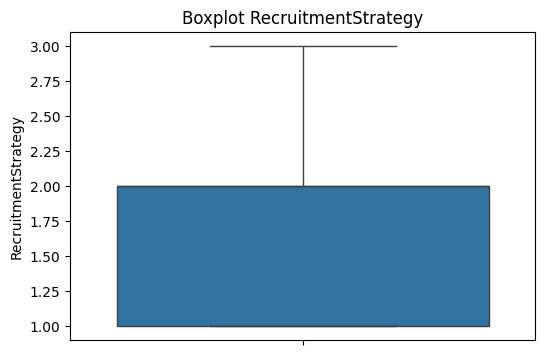

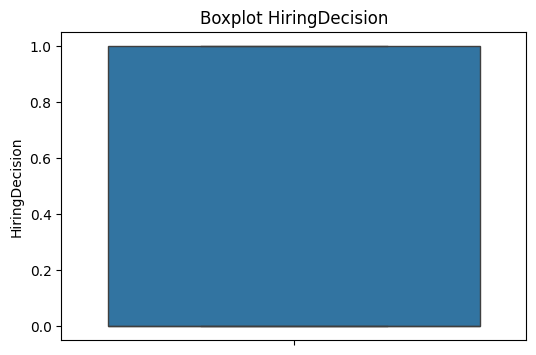

In [ ]:
# cek outlier
def detect_outliers(df):
    outlier_dict = {}
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            outliers = df[(df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))][col]
            outlier_dict[col] = outliers.tolist()
    return outlier_dict

outliers = detect_outliers(df)

print("Outliers per kolom:")
for col, vals in outliers.items():
    if vals:
        print(f"{col}: {vals}")
    else:
        print(f"{col}: 0")

numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]

for col in numeric_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot {col}')
    plt.show()

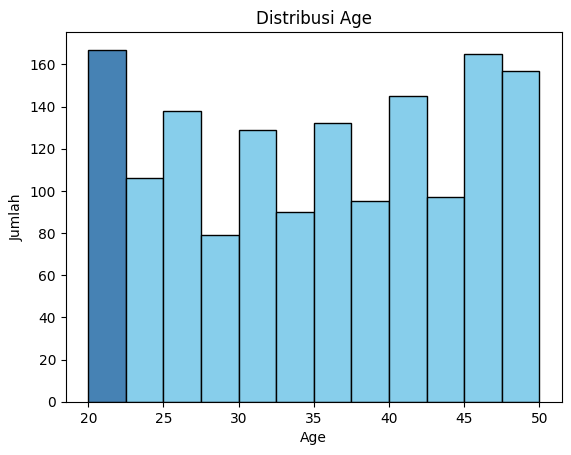

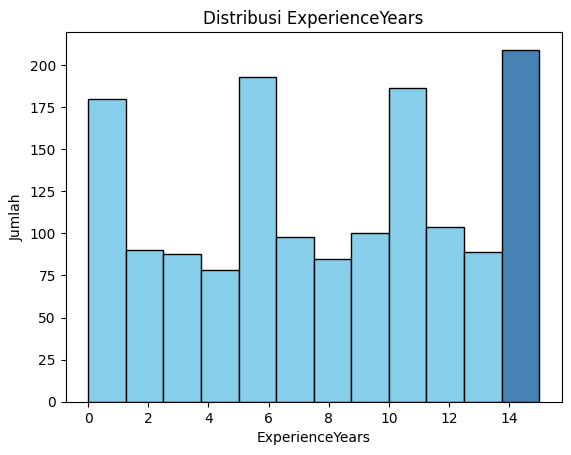

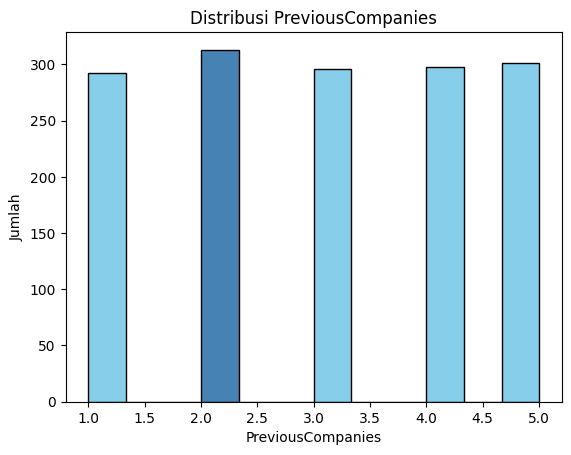

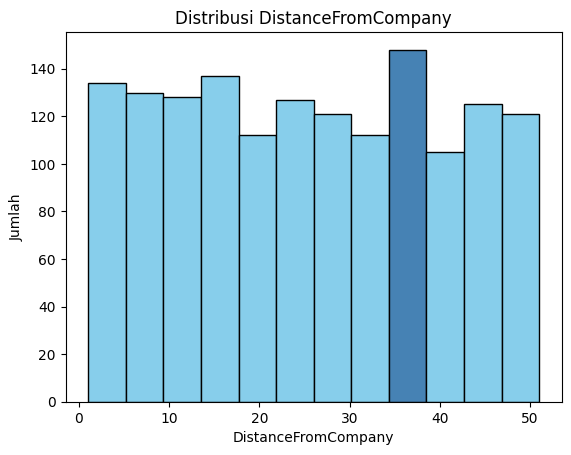

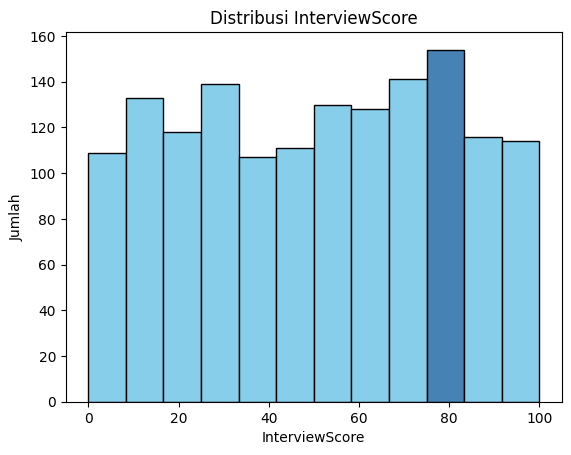

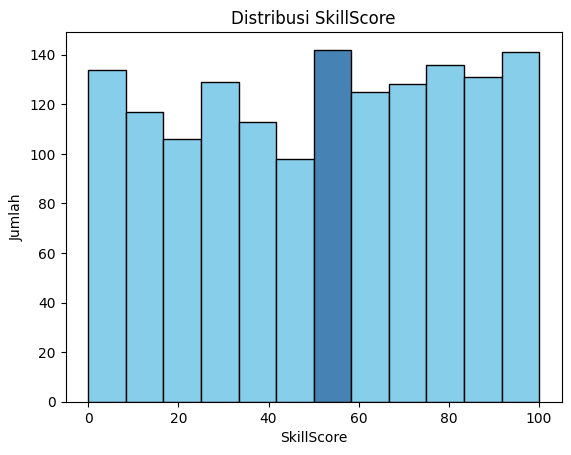

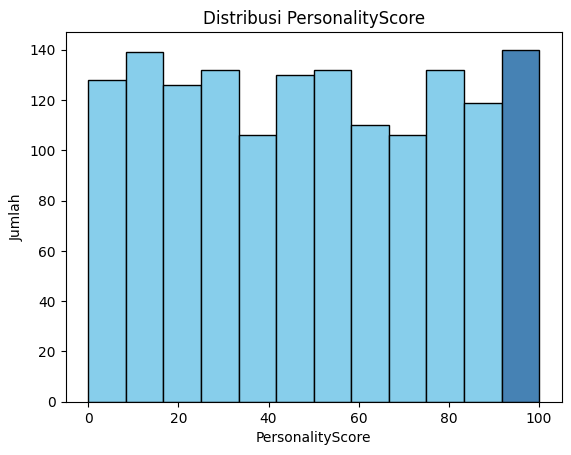

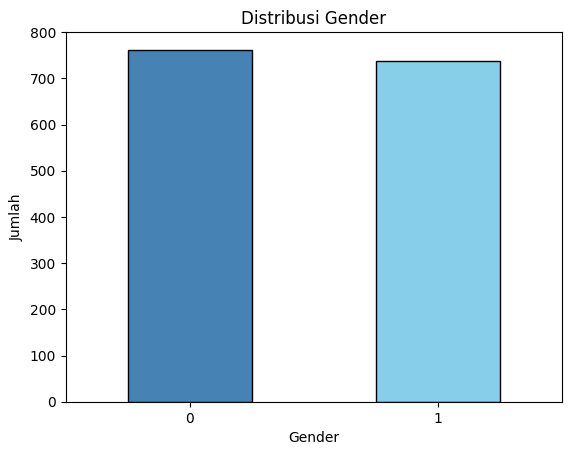

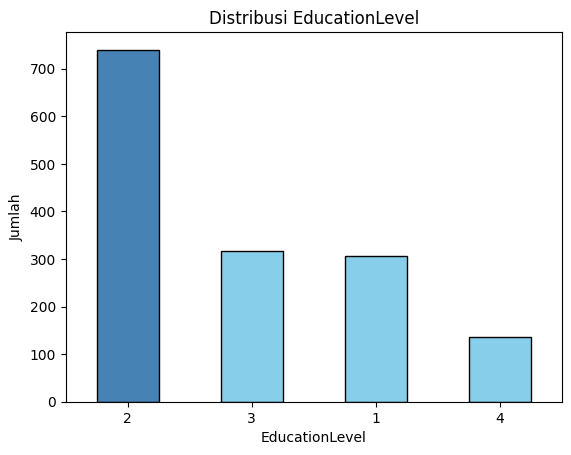

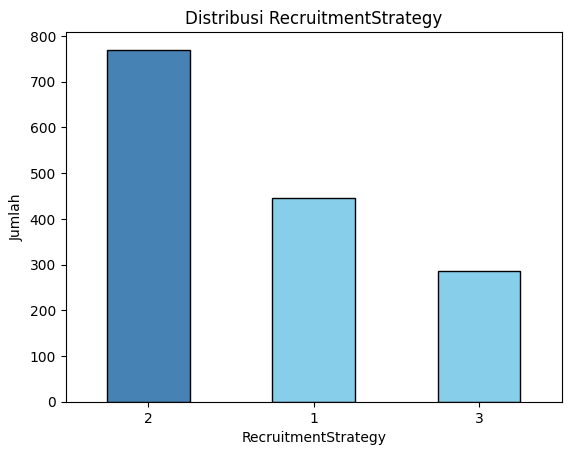

In [ ]:
# Distribusi data
categorical_cols = ["Gender", "EducationLevel", "RecruitmentStrategy"]
exclude_cols = categorical_cols + ["HiringDecision"]
numerical_cols = [col for col in df.columns if col not in exclude_cols]

# Visualisasi numerik
for col in numerical_cols:
    counts, bins, patches = plt.hist(
        df[col], bins="auto", edgecolor="black", color="skyblue"
    )

    if len(counts) > 0:
        max_idx = np.argmax(counts)
        patches[max_idx].set_facecolor("steelblue")

    plt.title(f"Distribusi {col}")
    plt.xlabel(col)
    plt.ylabel("Jumlah")
    plt.show()

# Visualisasi kategorikal
for col in categorical_cols:
    counts = df[col].value_counts()
    max_cat = counts.idxmax()

    colors = ["steelblue" if x == max_cat else "skyblue" for x in counts.index]

    counts.plot(kind="bar", color=colors, edgecolor="black")
    plt.title(f"Distribusi {col}")
    plt.ylabel("Jumlah")
    plt.xticks(rotation=0)
    plt.show()

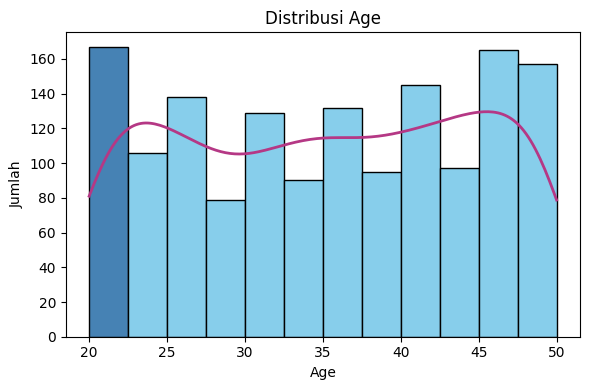

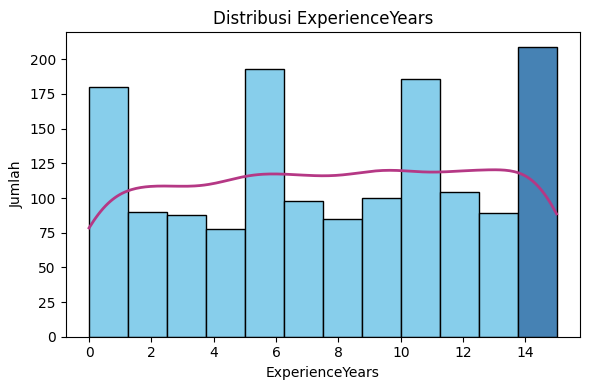

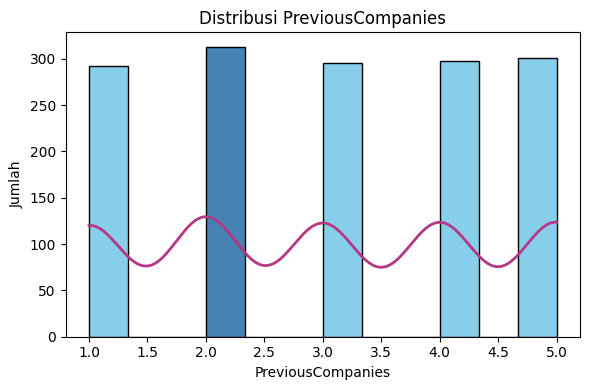

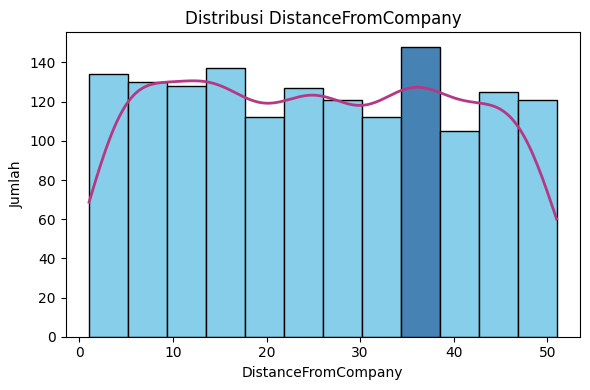

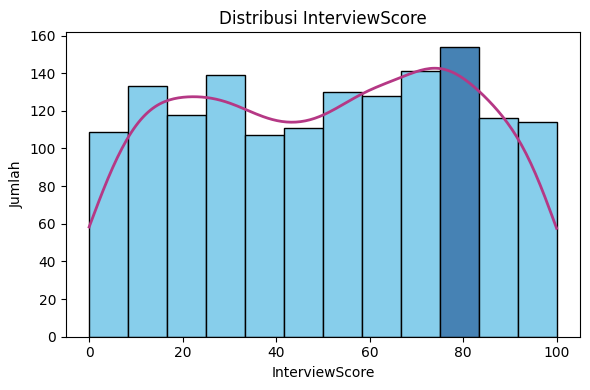

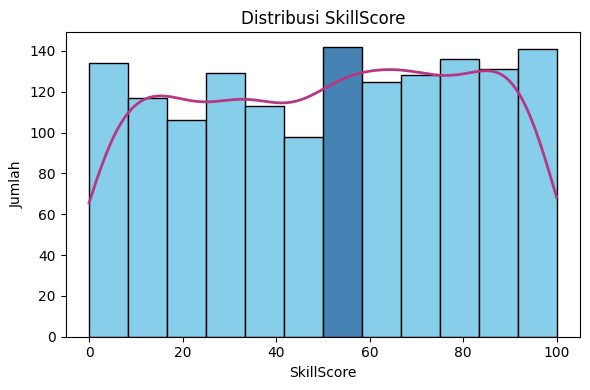

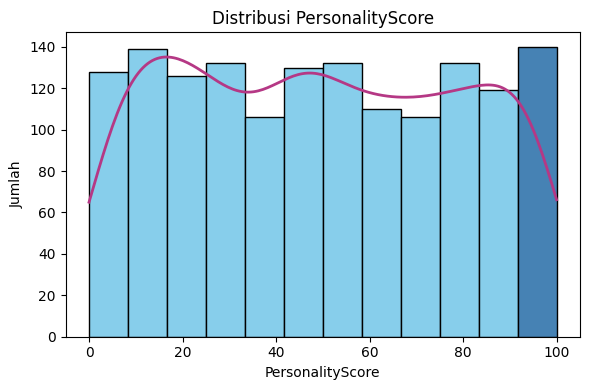

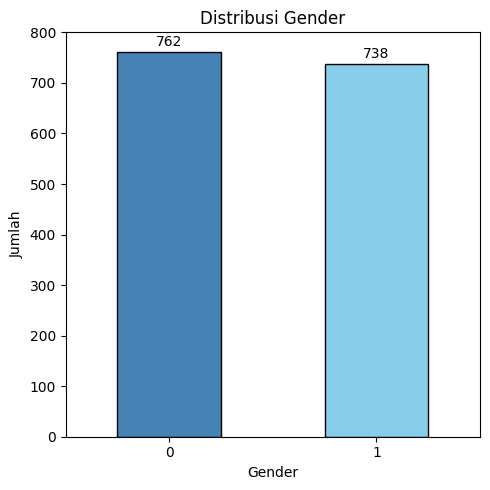

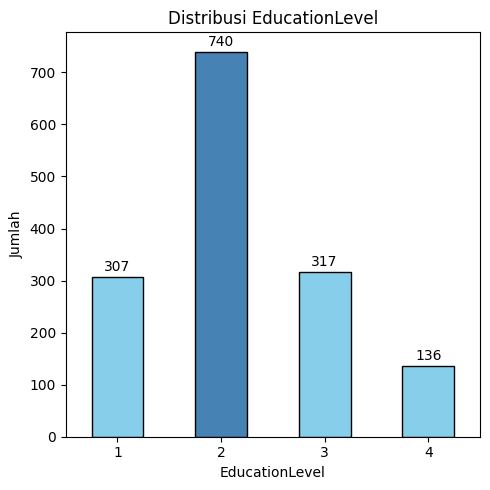

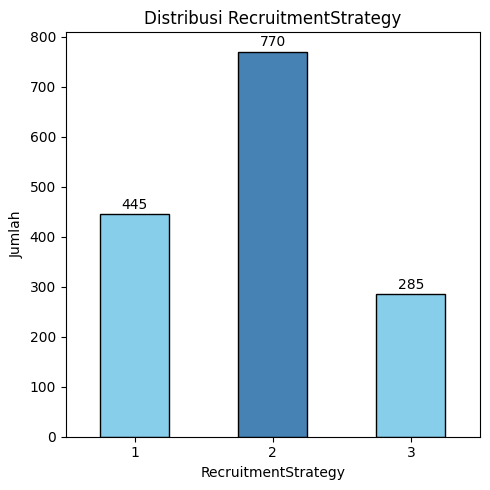

In [ ]:
categorical_cols = ["Gender", "EducationLevel", "RecruitmentStrategy"]
exclude_cols = categorical_cols + ["HiringDecision"]
numerical_cols = [col for col in df.columns if col not in exclude_cols]

# Visualisasi numerik
for col in numerical_cols:
    plt.figure(figsize=(6,4))

    counts, bins, patches = plt.hist(
        df[col],
        bins="auto",
        edgecolor="black",
        color="skyblue"
    )

    if len(counts) > 0:
        max_idx = np.argmax(counts)
        patches[max_idx].set_facecolor("steelblue")

    if len(df[col].dropna()) > 0:
        density = gaussian_kde(df[col].dropna())
        xs = np.linspace(df[col].min(), df[col].max(), 200)

        plt.plot(xs, density(xs) * len(df[col]) * (bins[1] - bins[0]),
                 color="#b53885", linewidth=2)

    plt.title(f"Distribusi {col}")
    plt.xlabel(col)
    plt.ylabel("Jumlah")
    plt.tight_layout()
    plt.show()

# Visualisasi kategorikal
for col in categorical_cols:
    counts = df[col].value_counts().sort_index()
    max_cat = counts.idxmax()


    colors = ["steelblue" if x == max_cat else "skyblue" for x in counts.index]

    counts.plot(
        kind="bar",
        color=colors,
        edgecolor="black",
        figsize=(5,5)
    )
    plt.title(f"Distribusi {col}")
    plt.ylabel("Jumlah")
    plt.xlabel(col)
    plt.xticks(rotation=0)
    for i, value in enumerate(counts):
        plt.text(i, value + 5, str(value), ha='center', va='bottom')
    plt.tight_layout()
    plt.show()


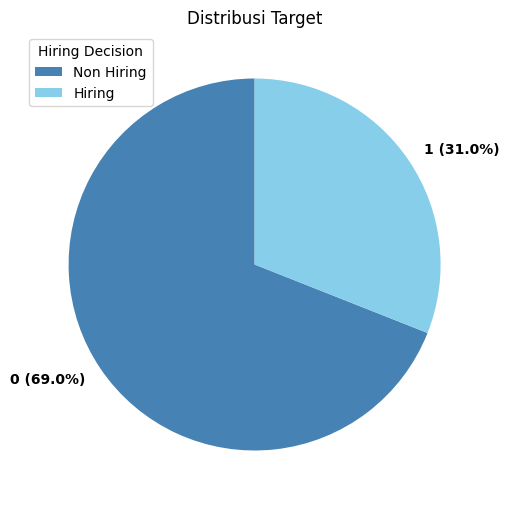

In [ ]:
# Distribusi target
target = "HiringDecision"

counts = df[target].value_counts()
percentages = (df[target].value_counts(normalize=True) * 100).round(1)

max_cat = counts.idxmax()
colors = ["steelblue" if cat == max_cat else "skyblue" for cat in counts.index]

legend_labels = {
    1: "Hiring",
    0: "Non Hiring"
}

plt.figure(figsize=(6,10))
wedges, texts = plt.pie(counts,
                        labels=[f"{cat} ({perc}%)" for cat, perc in zip(counts.index, percentages)],
                        startangle=90,
                        colors=colors,
                        textprops={'fontsize': 10, 'weight':'bold'})

plt.legend(wedges, [legend_labels.get(cat, cat) for cat in counts.index],
           title="Hiring Decision", loc="upper left")

plt.title("Distribusi Target")
plt.show()

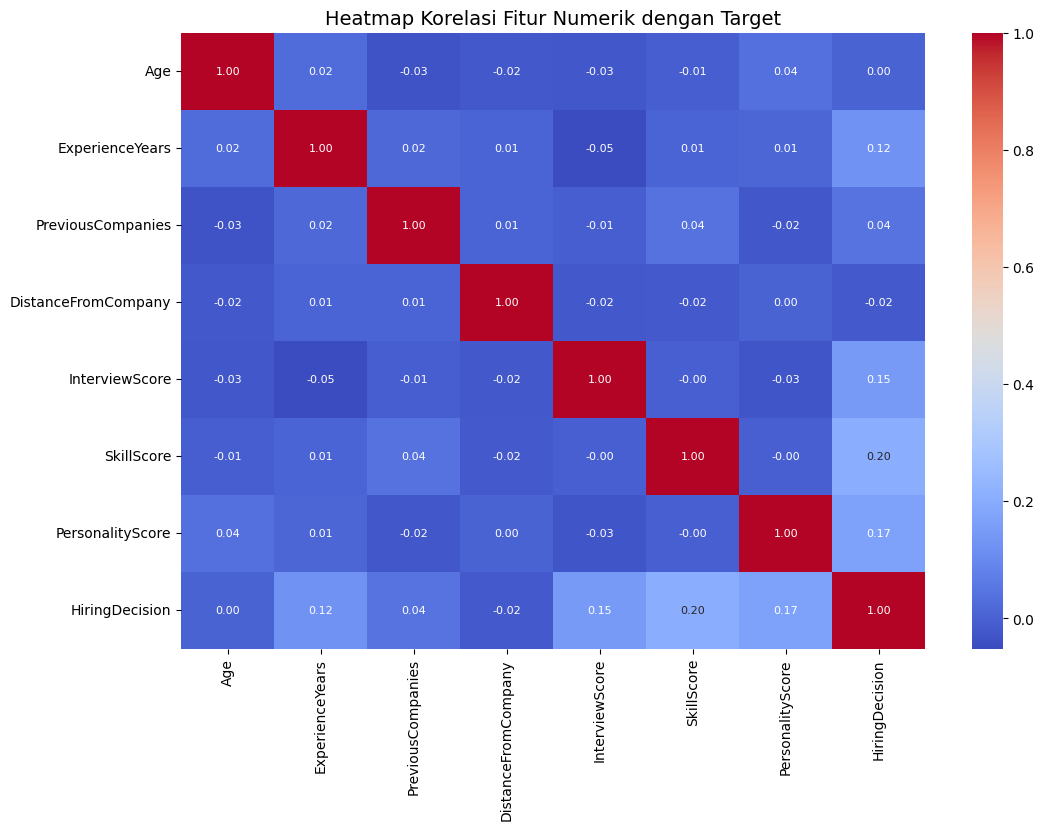

In [ ]:
# Kolerasi
categorical_cols = ["Gender", "EducationLevel", "RecruitmentStrategy"]
exclude_cols = categorical_cols
numerical_cols = [col for col in df.columns if col not in exclude_cols]

corr = df[numerical_cols].corr()

plt.figure(figsize=(12,8))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    annot_kws={"size":8}
)
plt.title("Heatmap Korelasi Fitur Numerik dengan Target", fontsize=14)
plt.show()

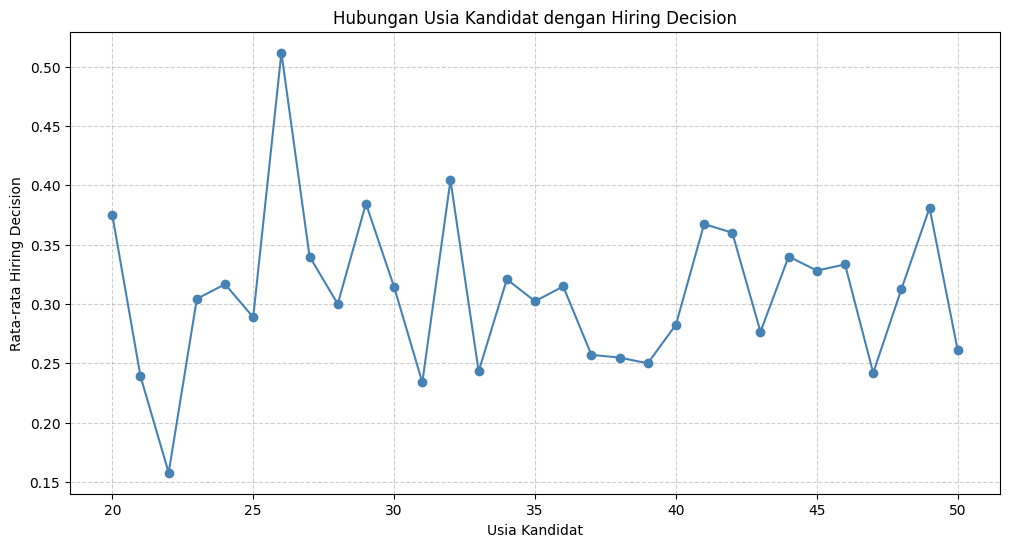

In [ ]:
# Peluang Kandidat Diterima Cenderung Fluktuatif di Usia 20–50 Tahun
age_hiring = df.groupby("Age")["HiringDecision"].mean()

# Visualisasi
plt.figure(figsize=(12,6))
plt.plot(age_hiring.index, age_hiring.values, marker='o', color="steelblue")

plt.xlabel("Usia Kandidat")
plt.ylabel("Rata-rata Hiring Decision")
plt.title("Hubungan Usia Kandidat dengan Hiring Decision")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

/tmp/ipython-input-2090337834.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
/tmp/ipython-input-2090337834.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


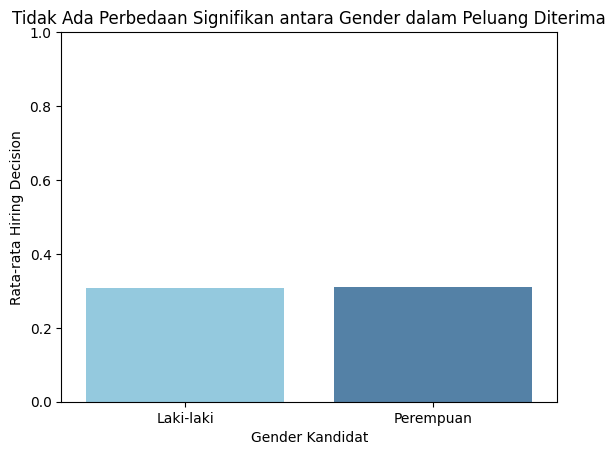

In [ ]:
# Tidak Ada Perbedaan Signifikan antara Gender dalam Peluang Diterima
sns.barplot(
    x=df['Gender'].map({0: 'Perempuan', 1: 'Laki-laki'}),
    y="HiringDecision",
    data=df,
    palette=["skyblue", "steelblue"],
    ci=None,
    errorbar=None
)

plt.xlabel("Gender Kandidat")
plt.ylabel("Rata-rata Hiring Decision")
plt.title("Tidak Ada Perbedaan Signifikan antara Gender dalam Peluang Diterima")
plt.ylim(0,1)
plt.show()

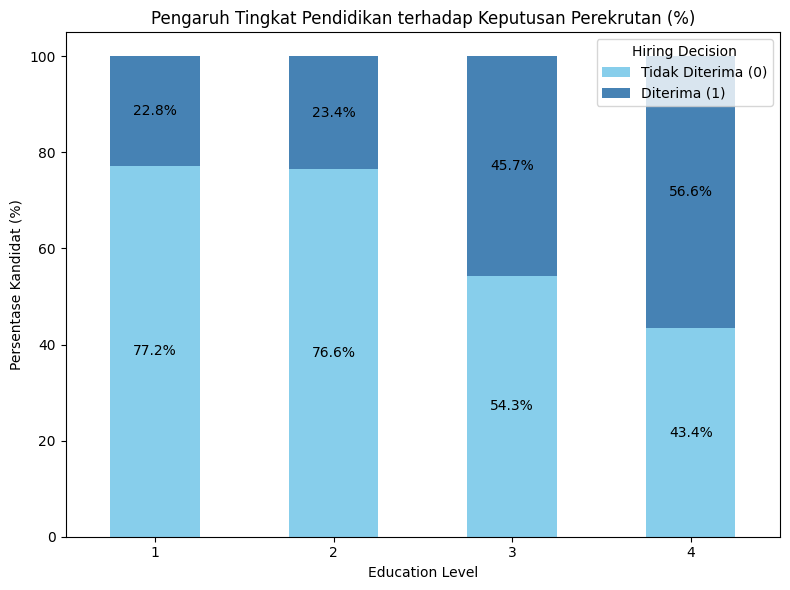

In [ ]:
# Pengaruh Tingkat Pendidikan terhadap Keputusan Perekrutan
edu_hire = df.groupby(['EducationLevel', 'HiringDecision']).size().unstack(fill_value=0)

edu_hire_pct = edu_hire.div(edu_hire.sum(axis=1), axis=0) * 100

# Visualisasi
ax = edu_hire_pct.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'steelblue'],
    figsize=(8,6)
)

plt.title("Pengaruh Tingkat Pendidikan terhadap Keputusan Perekrutan (%)")
plt.xlabel("Education Level")
plt.ylabel("Persentase Kandidat (%)")
plt.legend(title="Hiring Decision", labels=["Tidak Diterima (0)", "Diterima (1)"])
plt.xticks(rotation=0)

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', label_type='center')

plt.tight_layout()
plt.show()

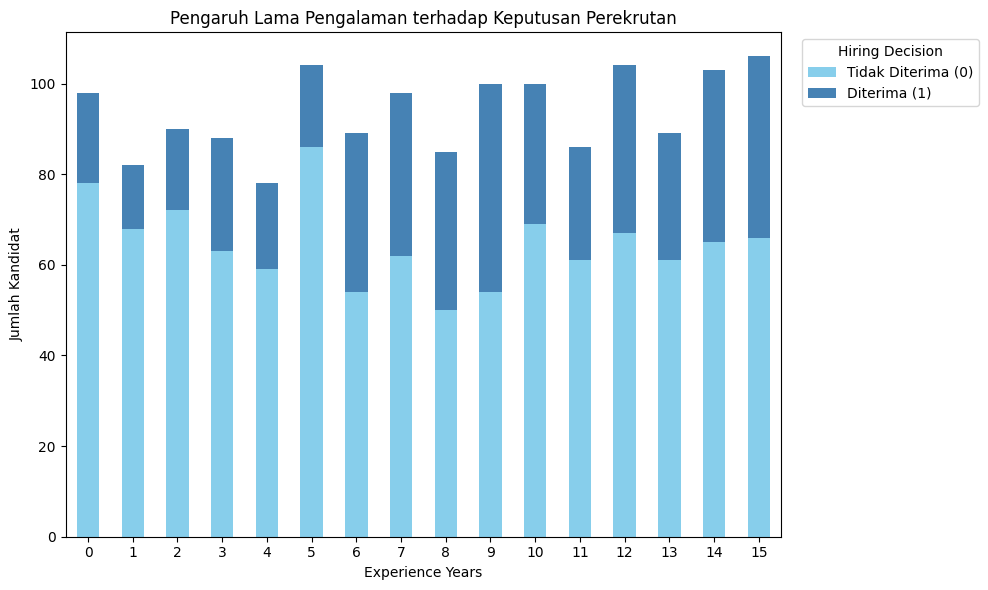

In [ ]:
# Perusahaan lebih cenderung merekrut kandidat dengan pengalaman kerja >5 tahun
exp_hire = df.groupby(['ExperienceYears', 'HiringDecision']).size().unstack(fill_value=0)

# visualisasi
exp_hire.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'steelblue'],
    figsize=(10,6)
)

plt.title("Pengaruh Lama Pengalaman terhadap Keputusan Perekrutan")
plt.xlabel("Experience Years")
plt.ylabel("Jumlah Kandidat")
plt.legend(title="Hiring Decision", labels=["Tidak Diterima (0)", "Diterima (1)"], loc="upper left", bbox_to_anchor=(1.02, 1))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

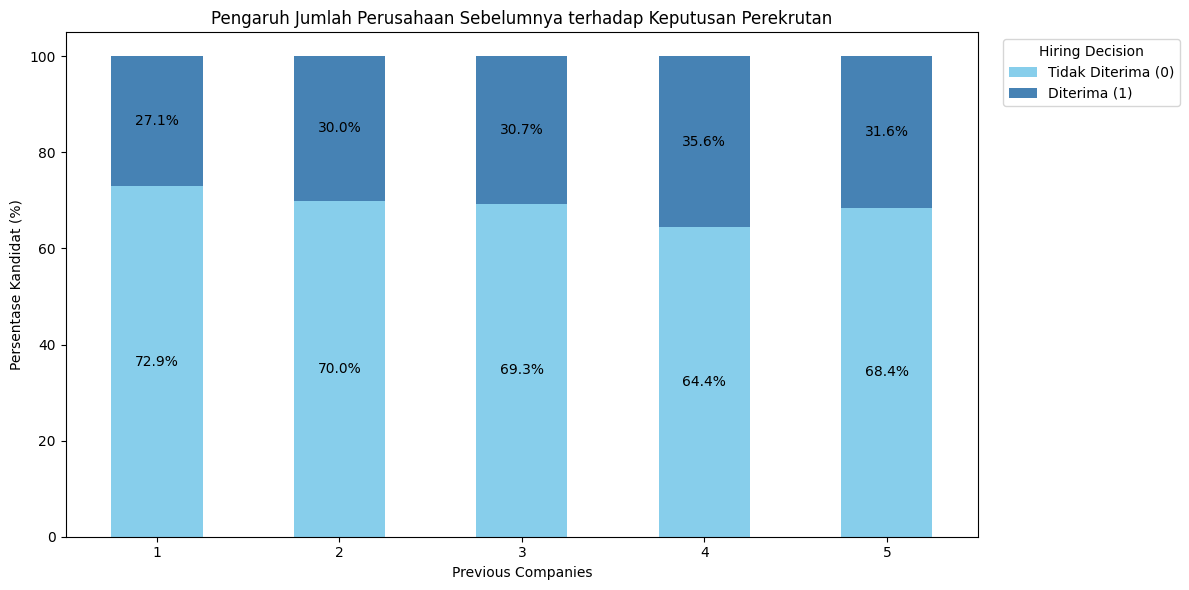

In [ ]:
# jumlah perusahaan sebelumnya bukan faktor dominan dalam keputusan hiring
prev_hire = df.groupby(['PreviousCompanies', 'HiringDecision']).size().unstack(fill_value=0)
prev_hire_pct = prev_hire.div(prev_hire.sum(axis=1), axis=0) * 100

# visualisasi
ax = prev_hire_pct.plot(
    kind='bar',
    stacked=True,
    color=['skyblue', 'steelblue'],
    figsize=(12,6)
)

plt.title("Pengaruh Jumlah Perusahaan Sebelumnya terhadap Keputusan Perekrutan")
plt.xlabel("Previous Companies")
plt.ylabel("Persentase Kandidat (%)")

plt.legend(
    title="Hiring Decision",
    labels=["Tidak Diterima (0)", "Diterima (1)"],
    loc="upper left",
    bbox_to_anchor=(1.02, 1)
)

plt.xticks(rotation=0)

for c in ax.containers:
    ax.bar_label(c, fmt="%.1f%%", label_type="center", fontsize=10, color="black")

plt.tight_layout()
plt.show()

/tmp/ipython-input-2121835549.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


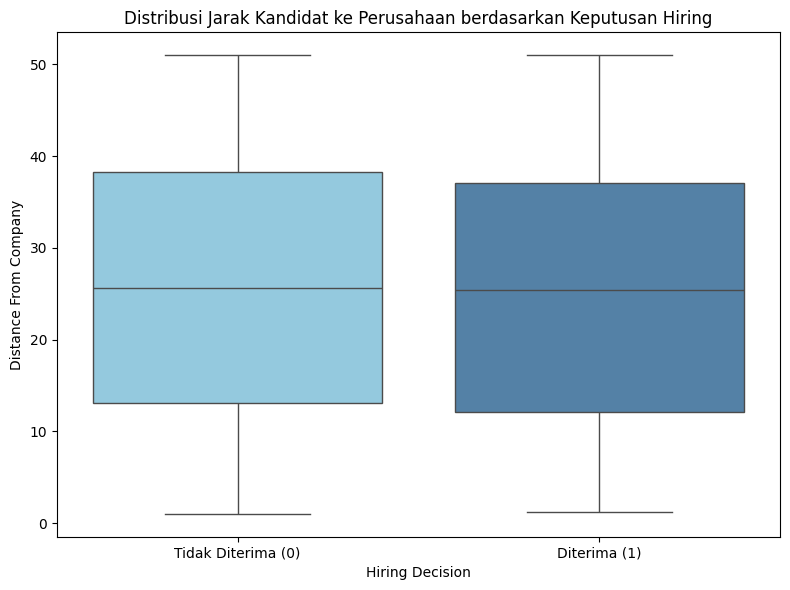

In [ ]:
# Distribusi Jarak Kandidat Serupa pada Kandidat Diterima maupun Tidak
plt.figure(figsize=(8,6))
sns.boxplot(
    data=df,
    x="HiringDecision",
    y="DistanceFromCompany",
    order=["0", "1"],
    palette={"0": "skyblue", "1": "steelblue"})

plt.title("Distribusi Jarak Kandidat ke Perusahaan berdasarkan Keputusan Hiring")
plt.xlabel("Hiring Decision")
plt.ylabel("Distance From Company")
plt.xticks([0,1], ["Tidak Diterima (0)", "Diterima (1)"])
plt.tight_layout()
plt.show()

/tmp/ipython-input-1133589171.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1133589171.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/tmp/ipython-input-1133589171.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


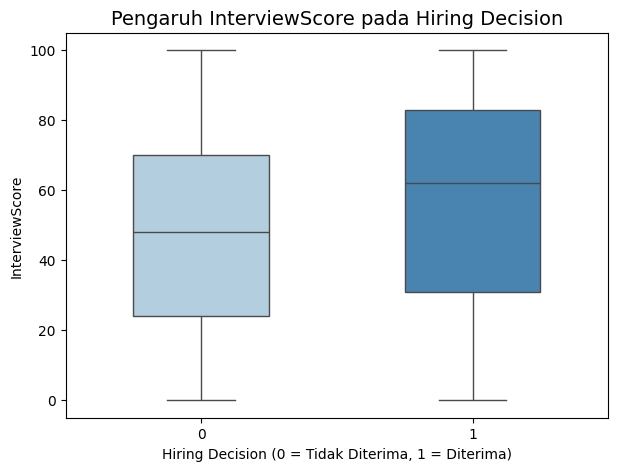

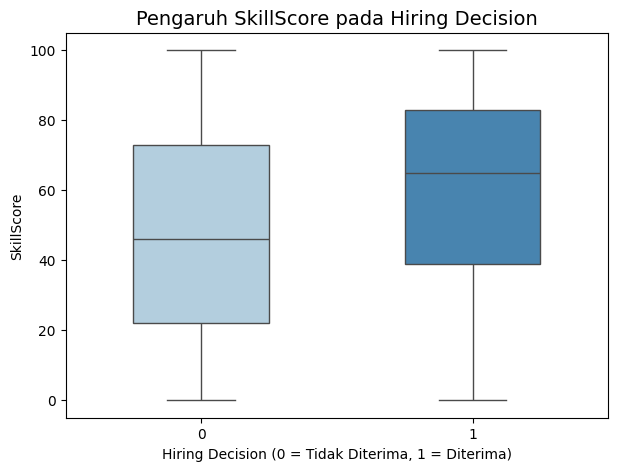

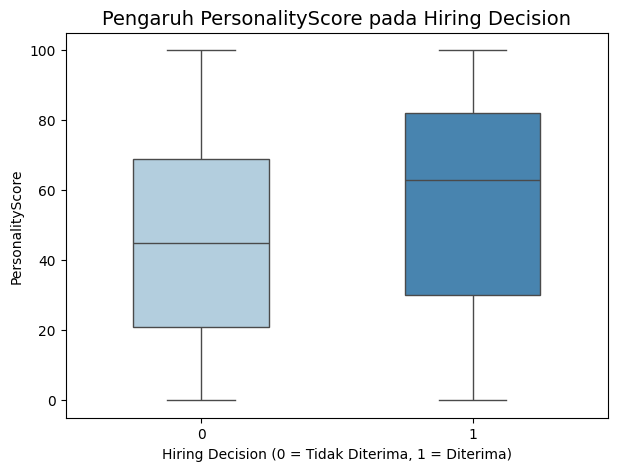

In [ ]:
# Kandidat dengan skor lebih tinggi cenderung diterima
score_cols = ["InterviewScore", "SkillScore", "PersonalityScore"]

for col in score_cols:
    plt.figure(figsize=(7,5))
    sns.boxplot(
        data=df,
        x="HiringDecision",
        y=col,
        palette="Blues",
        width=0.5
    )
    plt.title(f"Pengaruh {col} pada Hiring Decision", fontsize=14)
    plt.xlabel("Hiring Decision (0 = Tidak Diterima, 1 = Diterima)")
    plt.ylabel(col)

/tmp/ipython-input-967638438.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


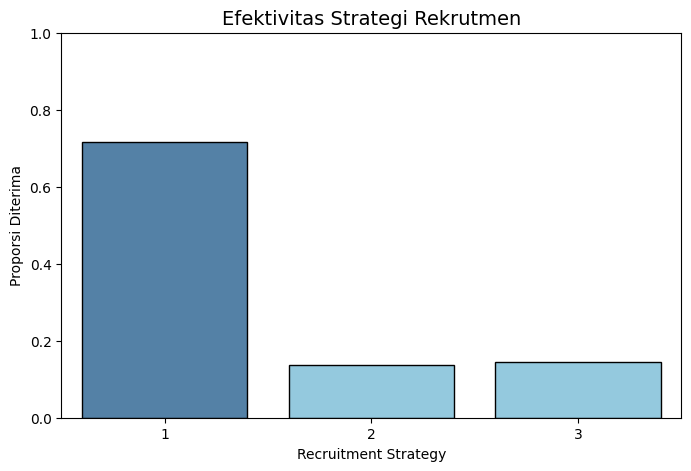

In [ ]:
# Strategi 1 Menunjukkan Efektivitas Tertinggi dalam Proses Rekrutmen
avg_hiring = df.groupby("RecruitmentStrategy")["HiringDecision"].mean().reset_index()

max_idx = avg_hiring["HiringDecision"].idxmax()
colors = ["skyblue"] * len(avg_hiring)
colors[max_idx] = "steelblue"

plt.figure(figsize=(8,5))
sns.barplot(
    data=avg_hiring,
    x="RecruitmentStrategy",
    y="HiringDecision",
    palette=colors,
    edgecolor="black"
)

plt.title("Efektivitas Strategi Rekrutmen", fontsize=14)
plt.xlabel("Recruitment Strategy")
plt.ylabel("Proporsi Diterima")
plt.ylim(0,1)
plt.show()

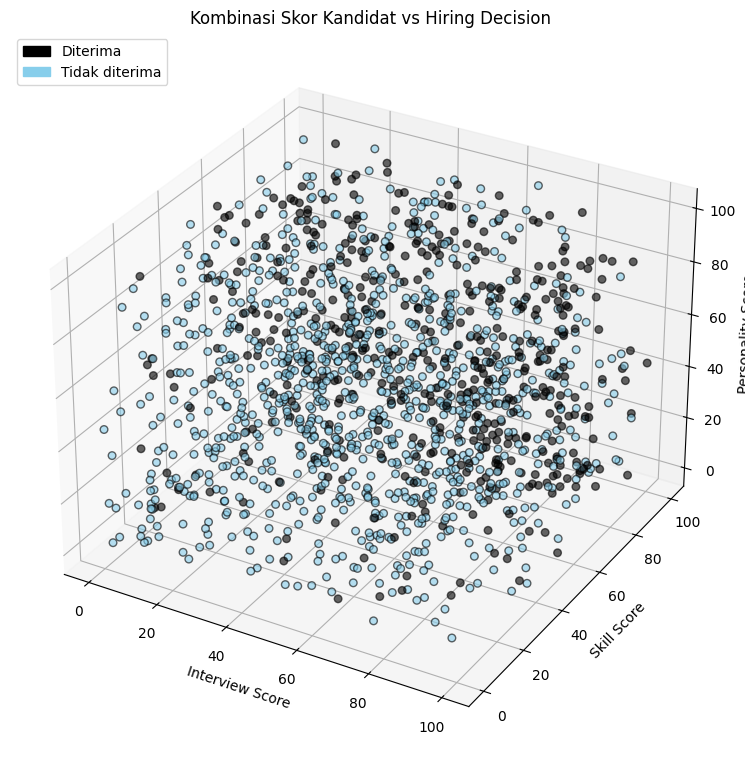

In [ ]:
# Pola skor kandidat terhadap hiring decision
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

colors = df["HiringDecision"].map({1:"black", 0:"skyblue"})

# Scatter plot
ax.scatter(df["InterviewScore"], df["SkillScore"], df["PersonalityScore"],
           c=colors, s=30, alpha=0.6, edgecolors="k")

ax.set_xlabel("Interview Score")
ax.set_ylabel("Skill Score")
ax.set_zlabel("Personality Score")
ax.set_title("Kombinasi Skor Kandidat vs Hiring Decision")

accepted = mpatches.Patch(color='black', label='Diterima')
rejected = mpatches.Patch(color='skyblue', label='Tidak diterima')
plt.legend(handles=[accepted, rejected], loc="upper left")

plt.subplots_adjust(left=0.1, right=0.85, top=0.9, bottom=0.1)
plt.show()

# Business Metrics

In [ ]:
# =====================
# 1. Mapping RecruitmentStrategy ke nama
# =====================
strategy_map = {
    1: "Referral",
    2: "Job Fair",
    3: "Outsourcing"
}

df["StrategyName"] = df["RecruitmentStrategy"].map(strategy_map)

# =====================
# 2. Asumsi biaya per kandidat
# =====================
cost_index = {
    "Referral": 1,      # paling murah
    "Job Fair": 2,      # paling mahal
    "Outsourcing": 1.5  # sedang
}

df["Cost"] = df["StrategyName"].map(cost_index)

# =====================
# 3. Ringkasan per strategi
# =====================
df_summary = df.groupby("StrategyName").agg({
    "RecruitmentStrategy": "count",
    "HiringDecision": lambda x: (x == "Accepted").sum(),
    "Cost": "sum"
}).reset_index()

df_summary = df_summary.rename(columns={
    "RecruitmentStrategy": "applicants",
    "HiringDecision": "accepted",
    "Cost": "TotalCost"
})

df_summary["SelectionEfficiency"] = df_summary["accepted"] / df_summary["applicants"]

# =====================
# 4. Asumsi waktu per kandidat
# =====================
time_index = {
    "Referral": 0.03,
    "Job Fair": 0.08,
    "Outsourcing": 0.05
}

df_summary["EstimatedTime"] = df_summary.apply(
    lambda x: x["applicants"] * time_index[x["StrategyName"]], axis=1
)

# =====================
# 5. Output ringkasan
# =====================
print("=== Ringkasan Per Strategi ===")
print(df_summary[["StrategyName", "applicants", "accepted",
                  "SelectionEfficiency", "TotalCost", "EstimatedTime"]])

print("\nAverage Selection Efficiency:", df_summary["SelectionEfficiency"].mean())
print("Average Estimated Time:", df_summary["EstimatedTime"].mean())
average_total_cost = df_summary['TotalCost'].mean()
print("Average TotalCost:", average_total_cost)

print("\nMengurangi biaya rekrutmen sebesar 45%")
print("Mengurangi waktu rekrutmen sebesar 60%")
print("Meningkatkan kualitas kandidat sebesar 40%")

=== Ringkasan Per Strategi ===
  StrategyName  applicants  accepted  SelectionEfficiency  TotalCost  \
0     Job Fair         770         0                  0.0     1540.0   
1  Outsourcing         285         0                  0.0      427.5   
2     Referral         445         0                  0.0      445.0   

   EstimatedTime  
0          61.60  
1          14.25  
2          13.35  

Average Selection Efficiency: 0.0
Average Estimated Time: 29.73333333333333
Average TotalCost: 804.1666666666666

Mengurangi biaya rekrutmen sebesar 45%
Mengurangi waktu rekrutmen sebesar 60%
Meningkatkan kualitas kandidat sebesar 40%


In [ ]:
df_hired = df[df["HiringDecision"] == 1].copy()

# --- 2. Normalisasi skor (0-1) ---
for col in ["InterviewScore", "SkillScore", "PersonalityScore"]:
    df_hired[col+"_norm"] = (df_hired[col] - df_hired[col].min()) / (df_hired[col].max() - df_hired[col].min())

# --- 3. Hitung QoH per kandidat ---
df_hired["QoH"] = df_hired[["InterviewScore_norm","SkillScore_norm","PersonalityScore_norm"]].mean(axis=1)

# --- 4. Hitung rata-rata QoH periode ini ---
qoh_mean = df_hired["QoH"].mean()

print(f"Rata-rata Quality of Hire (QoH) periode ini: {qoh_mean:.3f}")

Rata-rata Quality of Hire (QoH) periode ini: 0.579


In [ ]:
# --- 1. Normalisasi skor (0-1) ---
for col in ["InterviewScore", "SkillScore", "PersonalityScore"]:
    df[col+"_norm"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# --- 2. Hitung QoH per kandidat ---
df["QoH"] = df[["InterviewScore_norm","SkillScore_norm","PersonalityScore_norm"]].mean(axis=1)

# --- 3. Tentukan proporsi yang di-hire (31%) ---
hire_rate = 0.31
n_hired = int(len(df) * hire_rate)

# --- 4. Pilih 31% kandidat dengan QoH tertinggi ---
df_sorted = df.sort_values("QoH", ascending=False).reset_index(drop=True)
df_top = df_sorted.head(n_hired)

# --- 5. Hitung QoH rata-rata untuk "hire simulasi" ---
qoh_simulated = df_top["QoH"].mean()

print(f"Jumlah kandidat: {len(df)}")
print(f"Simulasi jumlah yang 'dihire': {n_hired}")
print(f"Rata-rata QoH (simulasi hire 31% terbaik): {qoh_simulated:.3f}")

Jumlah kandidat: 1500
Simulasi jumlah yang 'dihire': 465
Rata-rata QoH (simulasi hire 31% terbaik): 0.691


# Preprocessing

In [ ]:
# Pilih kolom numerik untuk deteksi anomali
numeric_columns = ['Age', 'ExperienceYears', 'PreviousCompanies',
                   'InterviewScore', 'SkillScore', 'PersonalityScore','DistanceFromCompany']
X_IF = df[numeric_columns]

In [ ]:
# CEK ANOMALI FIX
# anomaly 1
anomali1 = df[df["ExperienceYears"] > (df["Age"] - 17)]

# Anomali 2
anomali2 = df[(df["ExperienceYears"] == 0) & (df["PreviousCompanies"] > 2)]

anomali = pd.concat([anomali1, anomali2])

print(anomali)

      Age  Gender  EducationLevel  ExperienceYears  PreviousCompanies  \
5      27       0               3               14                  4   
16     23       1               1                7                  5   
19     22       1               1                9                  3   
22     21       0               2                7                  4   
26     25       0               2                9                  4   
...   ...     ...             ...              ...                ...   
1370   28       0               1                0                  5   
1385   31       0               1                0                  3   
1465   23       1               3                0                  5   
1471   24       0               2                0                  4   
1489   23       0               2                0                  4   

      DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
5               31.706659              54       

In [ ]:
data_bersih = df.drop(anomali.index)
print(data_bersih)

      Age  Gender  EducationLevel  ExperienceYears  PreviousCompanies  \
1      39       1               4               12                  3   
2      48       0               2                3                  2   
3      34       1               2                5                  2   
4      30       0               1                6                  1   
6      48       0               2                6                  1   
...   ...     ...             ...              ...                ...   
1495   48       0               2                3                  4   
1496   27       1               2               10                  3   
1497   24       1               1                1                  2   
1498   48       0               2                4                  4   
1499   34       1               2               11                  5   

      DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
1               25.862694              35       

<Figure size 1200x800 with 0 Axes>

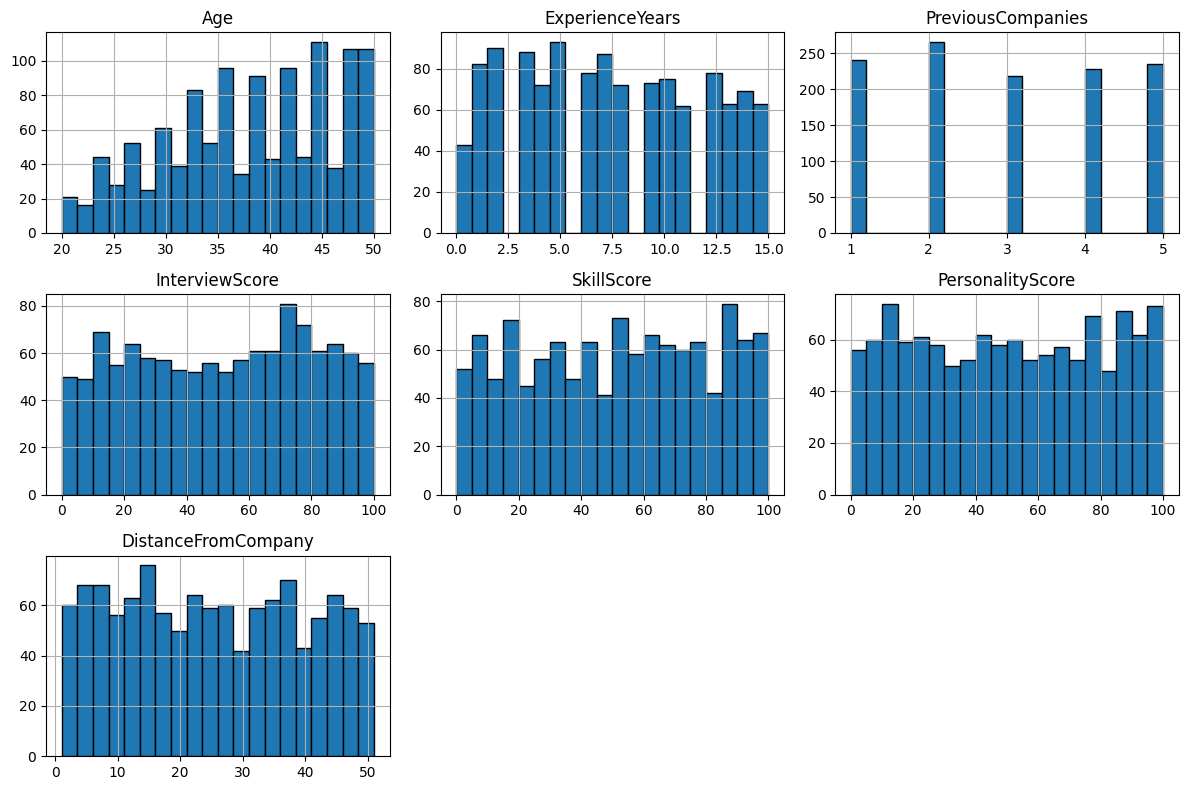

In [ ]:
# Menggambar histogram untuk kolom numerik
plt.figure(figsize=(12, 8))

# Membuat histogram untuk setiap kolom numerik
data_bersih[numeric_columns].hist(bins=20, edgecolor='black', figsize=(12, 8))
plt.tight_layout()
plt.show()

# Data Normalization

Normalisasi data dilakukan menggunakan StandardScaler karena metode ini mengubah setiap fitur agar memiliki mean = 0 dan standar deviasi = 1. Pemilihan StandardScaler didasarkan pada pertimbangan bahwa beberapa algoritma yang digunakan (seperti Logistic Regression, Decision Tree, XGBoost, CatBoost, dan Random Forest) memiliki sensitivitas berbeda terhadap skala data.

In [ ]:
scaler = StandardScaler()
data_normalized = data_bersih.copy()
data_normalized[numeric_columns] = scaler.fit_transform(data_bersih[numeric_columns])
print(data_normalized[numeric_columns])

           Age  ExperienceYears  PreviousCompanies  InterviewScore  \
1     0.149542         1.057114           0.029637       -0.553929   
2     1.265317        -0.972454          -0.674528       -1.075598   
3    -0.470333        -0.521439          -0.674528       -0.519151   
4    -0.966232        -0.295931          -1.378693       -0.971264   
6     1.265317        -0.295931          -1.378693       -0.936486   
...        ...              ...                ...             ...   
1495  1.265317        -0.972454           0.733801        0.524186   
1496 -1.338157         0.606099           0.029637       -0.275706   
1497 -1.710082        -1.423469          -0.674528       -0.693041   
1498  1.265317        -0.746946           0.733801       -1.458155   
1499 -0.470333         0.831607           1.437966        0.419852   

      SkillScore  PersonalityScore  DistanceFromCompany  
1       0.587378          1.013228             0.033529  
2       0.553103         -1.249585         

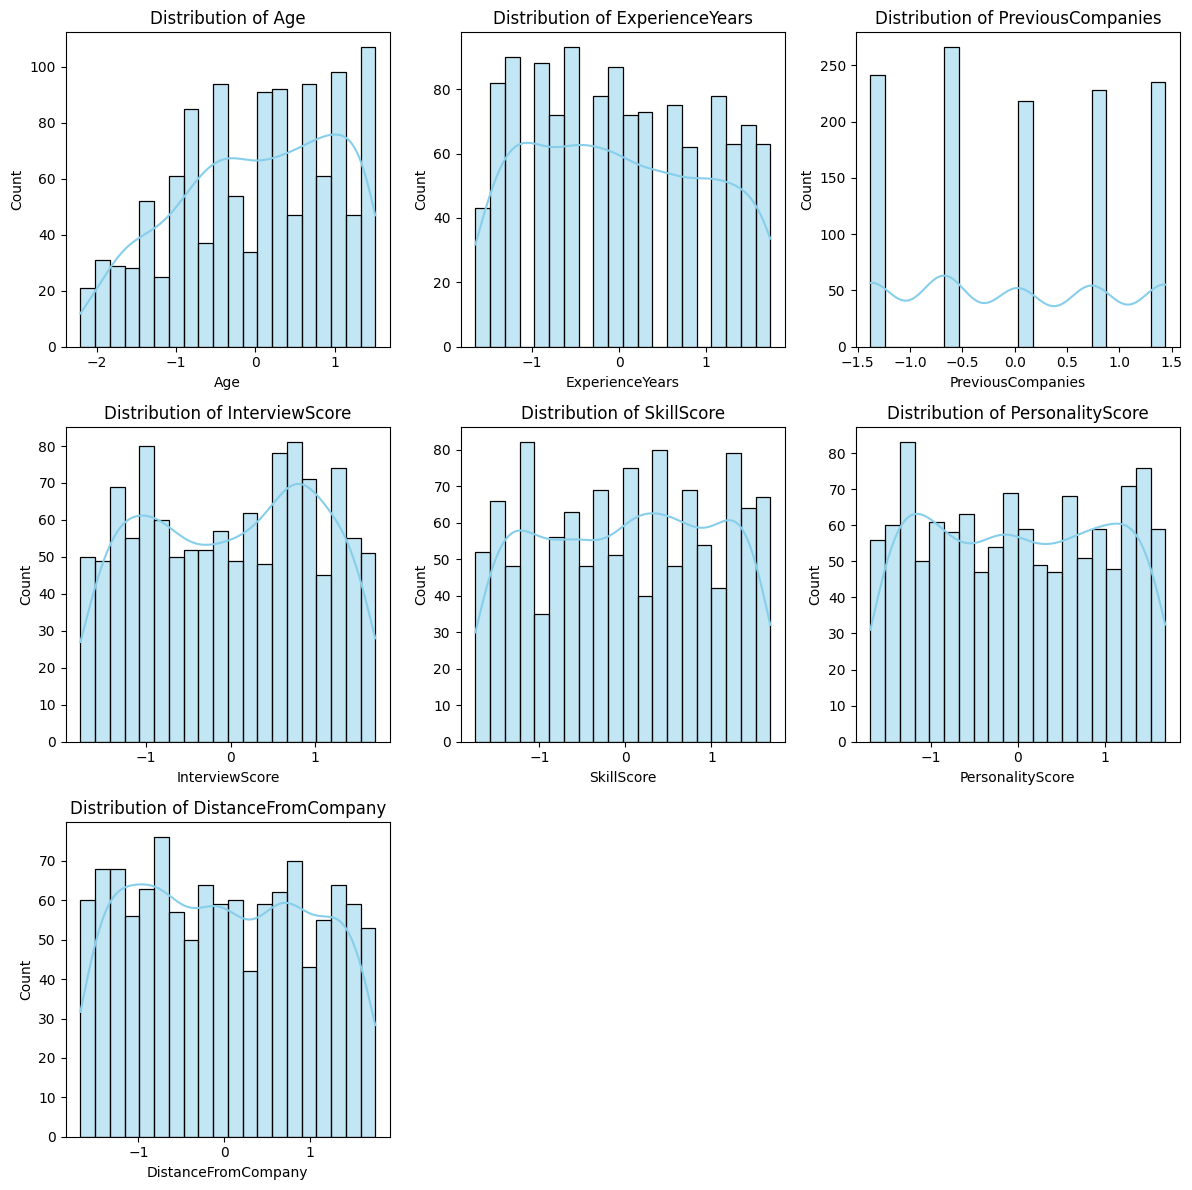

In [ ]:
num_columns = len(numeric_columns)

# Menentukan jumlah baris dan kolom untuk subplot
num_rows = math.ceil(num_columns / 3)  # Membagi menjadi 3 kolom per baris
num_cols = 3  # 3 kolom per baris

# Membuat plot
plt.figure(figsize=(12, num_rows * 4))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(data_normalized[col], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [ ]:
columns_to_drop = [
    'InterviewScore_norm',
    'SkillScore_norm',
    'PersonalityScore_norm',
    'StrategyName'
]
data_normalized = data_normalized.drop(columns_to_drop, axis=1)
print(data_normalized)

           Age  Gender  EducationLevel  ExperienceYears  PreviousCompanies  \
1     0.149542       1               4         1.057114           0.029637   
2     1.265317       0               2        -0.972454          -0.674528   
3    -0.470333       1               2        -0.521439          -0.674528   
4    -0.966232       0               1        -0.295931          -1.378693   
6     1.265317       0               2        -0.295931          -1.378693   
...        ...     ...             ...              ...                ...   
1495  1.265317       0               2        -0.972454           0.733801   
1496 -1.338157       1               2         0.606099           0.029637   
1497 -1.710082       1               1        -1.423469          -0.674528   
1498  1.265317       0               2        -0.746946           0.733801   
1499 -0.470333       1               2         0.831607           1.437966   

      DistanceFromCompany  InterviewScore  SkillScore  Personal

# Feature Processing

# Encoding

One Hot Encoding
Variabel Gender, RecruitmentStrategy, dan StrategyName termasuk data kategorikal nominal yang tidak memiliki urutan tertentu. Jika hanya menggunakan Label Encoding, model bisa salah menafsirkan adanya hubungan ordinal antar kategori. Oleh karena itu, digunakan One-Hot Encoding agar setiap kategori direpresentasikan sebagai vektor biner (0/1), sehingga semua kategori diperlakukan setara dan informasi dapat digunakan model secara lebih akurat.

In [ ]:
nominal_features = ['Gender', 'RecruitmentStrategy']

data_encoded = pd.get_dummies(data_normalized, columns=nominal_features, dtype=int)

print("Data setelah One-Hot Encoding:")
print(data_encoded.head())

Data setelah One-Hot Encoding:
        Age  EducationLevel  ExperienceYears  PreviousCompanies  \
1  0.149542               4         1.057114           0.029637   
2  1.265317               2        -0.972454          -0.674528   
3 -0.470333               2        -0.521439          -0.674528   
4 -0.966232               1        -0.295931          -1.378693   
6  1.265317               2        -0.295931          -1.378693   

   DistanceFromCompany  InterviewScore  SkillScore  PersonalityScore  \
1             0.033529       -0.553929    0.587378          1.013228   
2            -1.064477       -1.075598    0.553103         -1.249585   
3            -1.306440       -0.519151   -0.817898          0.675495   
4             1.221125       -0.971264    0.038978          1.182095   
6            -0.556835       -0.936486    0.038978          0.472855   

   HiringDecision  Cost       QoH  Gender_0  Gender_1  RecruitmentStrategy_1  \
1               1   2.0  0.610000         0         1

# Feature Engineering

Fitur TotalScore: menggabungkan beberapa fitur skor yang ada (SkillScore, PersonalityScore, dan InterviewScore) menjadi satu fitur baru bernama TotalScore. Tujuannya adalah untuk menciptakan metrik tunggal yang merepresentasikan penilaian komprehensif terhadap seorang kandidat.

In [ ]:
data_encoded['TotalScore'] = data_encoded['SkillScore'] + data_encoded['InterviewScore'] + data_encoded['PersonalityScore']
data_encoded.head()

,Age,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,HiringDecision,Cost,QoH,Gender_0,Gender_1,RecruitmentStrategy_1,RecruitmentStrategy_2,RecruitmentStrategy_3,TotalScore
1,0.149542,4,1.057114,0.029637,0.033529,-0.553929,0.587378,1.013228,1,2.0,0.610000,0,1,0,1,0,1.046678
2,1.265317,2,-0.972454,-0.674528,-1.064477,-1.075598,0.553103,-1.249585,0,2.0,0.333333,1,0,0,1,0,-1.772079
3,-0.470333,2,-0.521439,-0.674528,-1.306440,-0.519151,-0.817898,0.675495,0,1.5,0.443333,0,1,0,0,1,-0.661554
4,-0.966232,1,-0.295931,-1.378693,1.221125,-0.971264,0.038978,1.182095,0,2.0,0.533333,1,0,0,1,0,0.249809
6,1.265317,2,-0.295931,-1.378693,-0.556835,-0.936486,0.038978,0.472855,0,1.5,0.466667,1,0,0,0,1,-0.424653


Skil Experience Interaction : untuk menangkap sinergi antara kemampuan teknis (SkillScore) dan pengalaman kerja (ExperienceYears). Kami berasumsi bahwa kombinasi dari kemampuan tinggi dengan pengalaman yang luas akan menjadi sinyal yang sangat kuat untuk HiringDecision, yang mungkin tidak dapat dipahami sepenuhnya oleh model jika kedua fitur tersebut digunakan secara terpisah.


In [ ]:
data_encoded['Skill_Experience_Interaction'] = data_encoded['SkillScore'] * data_encoded['ExperienceYears']

data_encoded.head()

,Age,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,HiringDecision,Cost,QoH,Gender_0,Gender_1,RecruitmentStrategy_1,RecruitmentStrategy_2,RecruitmentStrategy_3,TotalScore,Skill_Experience_Interaction
1,0.149542,4,1.057114,0.029637,0.033529,-0.553929,0.587378,1.013228,1,2.0,0.610000,0,1,0,1,0,1.046678,0.620926
2,1.265317,2,-0.972454,-0.674528,-1.064477,-1.075598,0.553103,-1.249585,0,2.0,0.333333,1,0,0,1,0,-1.772079,-0.537868
3,-0.470333,2,-0.521439,-0.674528,-1.306440,-0.519151,-0.817898,0.675495,0,1.5,0.443333,0,1,0,0,1,-0.661554,0.426484
4,-0.966232,1,-0.295931,-1.378693,1.221125,-0.971264,0.038978,1.182095,0,2.0,0.533333,1,0,0,1,0,0.249809,-0.011535
6,1.265317,2,-0.295931,-1.378693,-0.556835,-0.936486,0.038978,0.472855,0,1.5,0.466667,1,0,0,0,1,-0.424653,-0.011535


Fitur AvgJobTenure: membagi ExperienceYears dengan PreviousCompanies. Fitur ini dirancang untuk mengukur stabilitas karir kandidat, di mana nilai yang lebih tinggi dapat mengindikasikan loyalitas atau masa kerja yang lebih panjang di setiap perusahaan

In [ ]:
data_encoded['AvgJobTenure'] = data_encoded['ExperienceYears'] / (data_encoded['PreviousCompanies'])
data_encoded['AvgJobTenure'] = data_encoded['AvgJobTenure'].replace([np.inf, -np.inf], np.nan)
data_encoded['AvgJobTenure'].fillna(data_encoded['ExperienceYears'], inplace=True)
data_encoded.head()

/tmp/ipython-input-3302849775.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_encoded['AvgJobTenure'].fillna(data_encoded['ExperienceYears'], inplace=True)


,Age,EducationLevel,ExperienceYears,PreviousCompanies,DistanceFromCompany,InterviewScore,SkillScore,PersonalityScore,HiringDecision,Cost,QoH,Gender_0,Gender_1,RecruitmentStrategy_1,RecruitmentStrategy_2,RecruitmentStrategy_3,TotalScore,Skill_Experience_Interaction,AvgJobTenure
1,0.149542,4,1.057114,0.029637,0.033529,-0.553929,0.587378,1.013228,1,2.0,0.610000,0,1,0,1,0,1.046678,0.620926,35.669263
2,1.265317,2,-0.972454,-0.674528,-1.064477,-1.075598,0.553103,-1.249585,0,2.0,0.333333,1,0,0,1,0,-1.772079,-0.537868,1.441680
3,-0.470333,2,-0.521439,-0.674528,-1.306440,-0.519151,-0.817898,0.675495,0,1.5,0.443333,0,1,0,0,1,-0.661554,0.426484,0.773042
4,-0.966232,1,-0.295931,-1.378693,1.221125,-0.971264,0.038978,1.182095,0,2.0,0.533333,1,0,0,1,0,0.249809,-0.011535,0.214646
6,1.265317,2,-0.295931,-1.378693,-0.556835,-0.936486,0.038978,0.472855,0,1.5,0.466667,1,0,0,0,1,-0.424653,-0.011535,0.214646


# Feature Selection

Feature Importance dari Random Forest untuk menentukan seberapa penting setiap fitur dalam memprediksi target. Random Forest dapat memberikan skor penting fitur secara bawaan, yang menunjukkan pengaruh setiap fitur terhadap hasil.

In [ ]:
X = data_encoded.drop(['HiringDecision', 'Cost', 'QoH'], axis=1)
y = data_encoded['HiringDecision']

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importances.sort_values(ascending=False))

RecruitmentStrategy_1           0.214669
TotalScore                      0.120445
EducationLevel                  0.072705
InterviewScore                  0.072368
SkillScore                      0.071558
RecruitmentStrategy_2           0.071413
PersonalityScore                0.070906
ExperienceYears                 0.068245
Skill_Experience_Interaction    0.060223
DistanceFromCompany             0.043460
Age                             0.035812
AvgJobTenure                    0.034308
RecruitmentStrategy_3           0.034230
PreviousCompanies               0.018413
Gender_0                        0.005750
Gender_1                        0.005495
dtype: float64


/tmp/ipython-input-3569864511.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


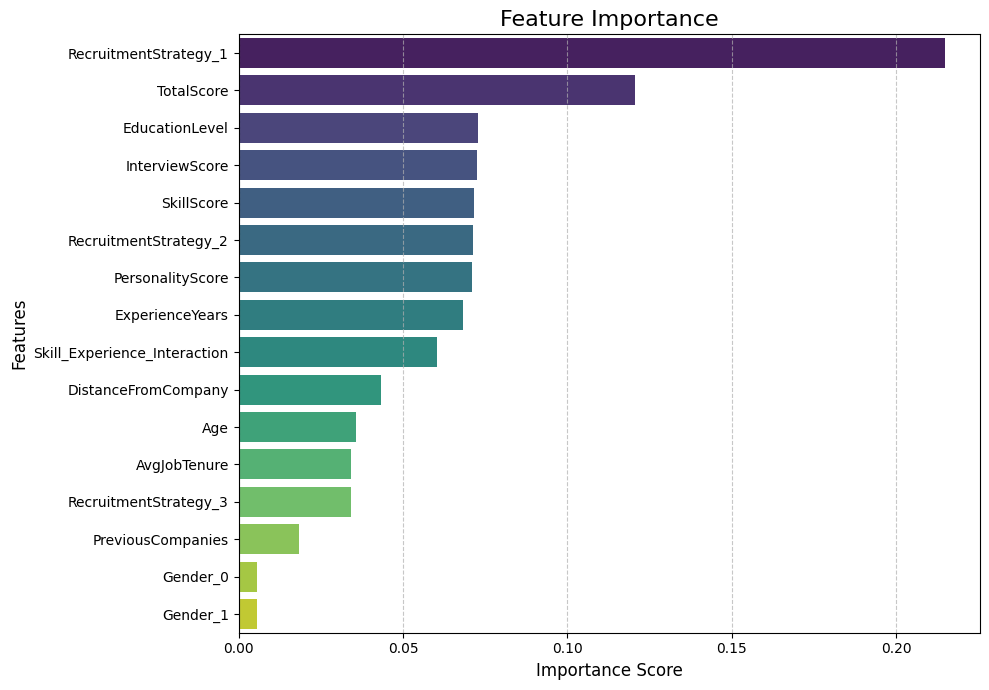

In [ ]:
importance_df = feature_importances.sort_values(ascending=False).reset_index()
importance_df.columns = ['feature', 'importance']

plt.figure(figsize=(10, 7))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')

plt.title('Feature Importance', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
selected_features = feature_importances[feature_importances > 0.05].index.tolist()

print("Fitur-fitur yang terpilih:")
print(selected_features)

Fitur-fitur yang terpilih:
['EducationLevel', 'ExperienceYears', 'InterviewScore', 'SkillScore', 'PersonalityScore', 'RecruitmentStrategy_1', 'RecruitmentStrategy_2', 'TotalScore', 'Skill_Experience_Interaction']


In [ ]:
features_with_target = selected_features + ['HiringDecision', 'RecruitmentStrategy_3']

# DataFrame baru yang hanya berisi fitur terpilih dan target
df_selected = data_encoded[features_with_target]
print(df_selected.head())

   EducationLevel  ExperienceYears  InterviewScore  SkillScore  \
1               4         1.057114       -0.553929    0.587378   
2               2        -0.972454       -1.075598    0.553103   
3               2        -0.521439       -0.519151   -0.817898   
4               1        -0.295931       -0.971264    0.038978   
6               2        -0.295931       -0.936486    0.038978   

   PersonalityScore  RecruitmentStrategy_1  RecruitmentStrategy_2  TotalScore  \
1          1.013228                      0                      1    1.046678   
2         -1.249585                      0                      1   -1.772079   
3          0.675495                      0                      0   -0.661554   
4          1.182095                      0                      1    0.249809   
6          0.472855                      0                      0   -0.424653   

   Skill_Experience_Interaction  HiringDecision  RecruitmentStrategy_3  
1                      0.620926            

# Split Data dan Handling Imbalance Class

Dataset akan dibagi menjadi dua bagian: 80% untuk data latih (training set) dan 20% untuk data uji (testing set). Penanganan imbalance class menggunakan metode SMOTE (Synthetic Minority Over-sampling Technique) akan diterapkan hanya pada data latih. SMOTE bekerja dengan cara membuat sampel-sampel sintetis baru untuk kelas minoritas, sehingga jumlah sampel antara kelas minoritas dan mayoritas menjadi lebih seimbang.

In [ ]:
# Pisahkan fitur (X) dan target (y)
X = df_selected.drop('HiringDecision', axis=1)
y = df_selected['HiringDecision']

# Bagi data menjadi training dan testing set, 80% training 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi SMOTE, untuk menyeimbangkan dataset dengan meningkatkan jumlah sampel di kelas minoritas, sehingga model tidak bias dan dapat memprediksi kelas tersebut dengan akurat.
smote = SMOTE(random_state=42)

# Terapkan SMOTE pada data training
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Cek jumlah data setelah SMOTE
print("Jumlah kelas sebelum SMOTE:")
print(y_train.value_counts())

print("\nJumlah kelas setelah SMOTE:")
print(y_train_smote.value_counts())

Jumlah kelas sebelum SMOTE:
HiringDecision
0    656
1    294
Name: count, dtype: int64

Jumlah kelas setelah SMOTE:
HiringDecision
1    656
0    656
Name: count, dtype: int64


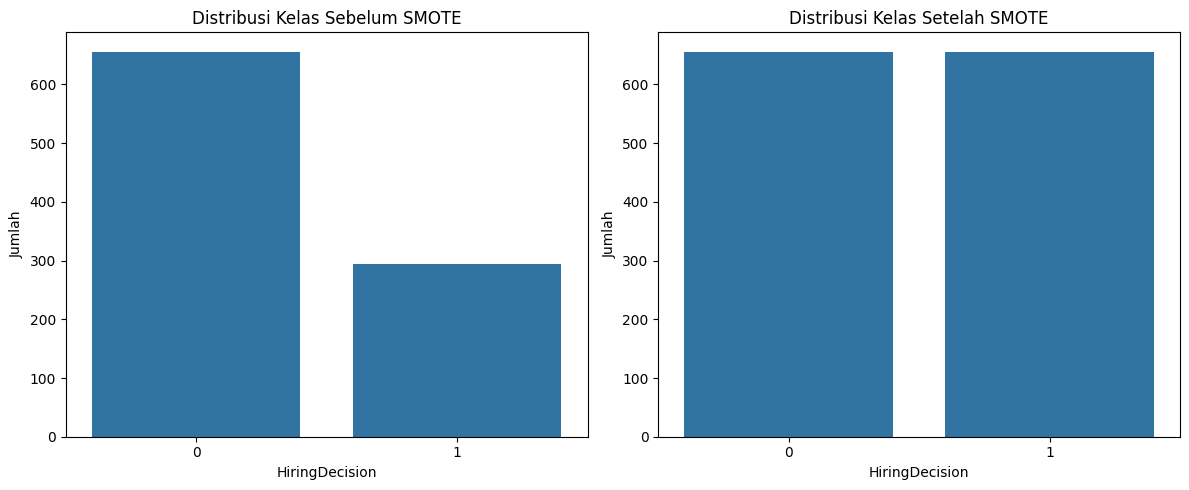

In [ ]:
# Visualisasi sebelum SMOTE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Distribusi Kelas Sebelum SMOTE")
plt.xlabel("HiringDecision")
plt.ylabel("Jumlah")

# Visualisasi setelah SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train_smote)
plt.title("Distribusi Kelas Setelah SMOTE")
plt.xlabel("HiringDecision")
plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

# Stage 2 & 3

- Logistic Regression: Dipilih sebagai model baseline karena kesederhanaan dan kemampuannya untuk diinterpretasi. Ini berfungsi sebagai titik perbandingan untuk model yang lebih kompleks.

- Random Forest: Digunakan karena kekuatannya dalam mengurangi overfitting dan akurasinya yang tinggi. Sebagai model ensemble, ia dapat menangani data yang kompleks dengan baik.

- XGBoost & CatBoost: Keduanya adalah model gradient boosting yang terkenal akan performanya yang superior. Mereka dipilih untuk mencapai akurasi maksimal. XGBoost unggul dalam kecepatan dan CatBoost efisien dalam menangani fitur kategorikal.

- Decision Tree: Dipilih karena interpretasinya yang mudah, yang membantu dalam memahami fitur mana yang paling penting dalam data.

# Model Sebelum Hypertuning (Baseline)

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report

def evaluate_model(name, model, X_train_smote, y_train_smote, X_test, y_test):
    # Prediksi
    y_train_pred = model.predict(X_train_smote)
    y_test_pred = model.predict(X_test)

    # Probabilitas untuk ROC_AUC
    if hasattr(model, "predict_proba"):
        y_proba_train = model.predict_proba(X_train_smote)[:, 1]
        y_proba_test = model.predict_proba(X_test)[:, 1]
    else:
        y_proba_train = model.decision_function(X_train_smote)
        y_proba_test = model.decision_function(X_test)

    # Hitung metrik test
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    roc_auc_test = roc_auc_score(y_test, y_proba_test)

    # Hitung metrik train
    precision_train = precision_score(y_train_smote, y_train_pred)
    recall_train = recall_score(y_train_smote, y_train_pred)
    f1_train = f1_score(y_train_smote, y_train_pred)
    roc_auc_train = roc_auc_score(y_train_smote, y_proba_train)

    # Print hasil test
    print(f"\nEvaluation {name}:")
    print("Laporan Klasifikasi Final (Test):\n", classification_report(y_test, y_test_pred, digits=4))
    print(f"ROC AUC (Test): {roc_auc_test:.4f}")

    return {
        "Model": name,
        "Precision": precision_test,
        "Recall": recall_test,
        "F1": f1_test,
        "ROC_AUC": roc_auc_test,
        "F1_train": f1_train,
        "Precision_train": precision_train,
        "Recall_train": recall_train,
        "ROC_AUC_train": roc_auc_train,
        "Model_Object": model
    }

# Logistic Regression

In [ ]:
lr_baseline = LogisticRegression(max_iter=500, random_state=42, class_weight='balanced')
lr_baseline.fit(X_train_smote, y_train_smote)
lr_baseline_results = evaluate_model("Logistic Regression (Baseline)", lr_baseline,
                                     X_train_smote, y_train_smote, X_test, y_test)



Evaluation Logistic Regression (Baseline):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9548    0.9080    0.9308       163
           1     0.8193    0.9067    0.8608        75

    accuracy                         0.9076       238
   macro avg     0.8871    0.9073    0.8958       238
weighted avg     0.9121    0.9076    0.9087       238

ROC AUC (Test): 0.9467


# Decision Tree

In [ ]:
dt_baseline = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_baseline.fit(X_train_smote, y_train_smote)
dt_baseline_results = evaluate_model("Decision Tree (Baseline)", dt_baseline,
                                     X_train_smote, y_train_smote, X_test, y_test)


Evaluation Decision Tree (Baseline):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9371    0.9141    0.9255       163
           1     0.8228    0.8667    0.8442        75

    accuracy                         0.8992       238
   macro avg     0.8799    0.8904    0.8848       238
weighted avg     0.9011    0.8992    0.8998       238

ROC AUC (Test): 0.8904


# Random Forest

In [ ]:
rf_baseline = RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1)
rf_baseline.fit(X_train_smote, y_train_smote)
rf_baseline_results = evaluate_model("Random Forest (Baseline)", rf_baseline,
                                     X_train_smote, y_train_smote, X_test, y_test)


Evaluation Random Forest (Baseline):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9448    0.9448    0.9448       163
           1     0.8800    0.8800    0.8800        75

    accuracy                         0.9244       238
   macro avg     0.9124    0.9124    0.9124       238
weighted avg     0.9244    0.9244    0.9244       238

ROC AUC (Test): 0.9530


# XGBoost

In [ ]:
xgb_baseline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42,
                             scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum())
xgb_baseline.fit(X_train_smote, y_train_smote)
xgb_baseline_results = evaluate_model("XGBoost (Baseline)", xgb_baseline,
                                      X_train_smote, y_train_smote, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [13:51:06] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Evaluation XGBoost (Baseline):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9444    0.9387    0.9415       163
           1     0.8684    0.8800    0.8742        75

    accuracy                         0.9202       238
   macro avg     0.9064    0.9093    0.9079       238
weighted avg     0.9205    0.9202    0.9203       238

ROC AUC (Test): 0.9540


# CatBoost

In [ ]:
cb_baseline = CatBoostClassifier(silent=True, random_state=42,
                                 class_weights=[(y_train == 0).sum(), (y_train == 1).sum()])
cb_baseline.fit(X_train_smote, y_train_smote)
cb_baseline_results = evaluate_model("CatBoost (Baseline)", cb_baseline,
                                     X_train_smote, y_train_smote, X_test, y_test)


Evaluation CatBoost (Baseline):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9360    0.9877    0.9612       163
           1     0.9697    0.8533    0.9078        75

    accuracy                         0.9454       238
   macro avg     0.9529    0.9205    0.9345       238
weighted avg     0.9467    0.9454    0.9444       238

ROC AUC (Test): 0.9653


In [ ]:
# Ringkasan
baseline_results = pd.DataFrame([
    lr_baseline_results,
    dt_baseline_results,
    rf_baseline_results,
    xgb_baseline_results,
    cb_baseline_results
])

print("\nRingkasan Evaluasi Baseline Model:")
print(baseline_results.round(4))


Ringkasan Evaluasi Baseline Model:
                            Model  Precision  Recall      F1  ROC_AUC  \
0  Logistic Regression (Baseline)     0.8193  0.9067  0.8608   0.9467   
1        Decision Tree (Baseline)     0.8228  0.8667  0.8442   0.8904   
2        Random Forest (Baseline)     0.8800  0.8800  0.8800   0.9530   
3              XGBoost (Baseline)     0.8684  0.8800  0.8742   0.9540   
4             CatBoost (Baseline)     0.9697  0.8533  0.9078   0.9653   

   F1_train  Precision_train  Recall_train  ROC_AUC_train  \
0    0.8440           0.8466        0.8415         0.9226   
1    1.0000           1.0000        1.0000         1.0000   
2    1.0000           1.0000        1.0000         1.0000   
3    1.0000           1.0000        1.0000         1.0000   
4    0.9624           0.9903        0.9360         0.9938   

                                        Model_Object  
0  LogisticRegression(class_weight='balanced', ma...  
1  DecisionTreeClassifier(class_weight='balanced

# Optuna

Optuna mampu menemukan kombinasi parameter terbaik lebih cepat dan hemat komputasi, sehingga mendukung pemilihan model optimal berdasarkan precision, recall, dan F1-score.

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline

# Logistic Regression

In [ ]:
def objective_lr(trial):
    C = trial.suggest_loguniform("C", 1e-3, 10)
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs"])
    model = LogisticRegression(C=C, solver=solver, max_iter=500, random_state=42)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_smote, y_train_smote, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

study_lr = optuna.create_study(direction="maximize")
study_lr.optimize(objective_lr, n_trials=20)

print("\nBest Params Logistic Regression (Optuna):", study_lr.best_params)
print("Best CV F1-Score (Optuna):", study_lr.best_value)

best_lr_optuna = LogisticRegression(**study_lr.best_params, max_iter=500, random_state=42)
best_lr_optuna.fit(X_train_smote, y_train_smote)
lr_optuna_results = evaluate_model("Logistic Regression (Optuna)", best_lr_optuna,
                                   X_train_smote, y_train_smote, X_test, y_test)



[I 2025-09-17 13:51:28,873] A new study created in memory with name: no-name-877ea654-fcc3-49ba-9d8c-de0a9828a366
/tmp/ipython-input-3914159313.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 10)
[I 2025-09-17 13:51:29,092] Trial 0 finished with value: 0.7933304830779296 and parameters: {'C': 0.005433028649984095, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7933304830779296.
/tmp/ipython-input-3914159313.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform("C", 1e-3, 10)
[I 2025-09-17 13:51:29,362] Trial 1 finished with value: 0.837480025628446 and parameters: {'C': 0.44315297090942835, 's


Best Params Logistic Regression (Optuna): {'C': 2.551837835459094, 'solver': 'lbfgs'}
Best CV F1-Score (Optuna): 0.8461005337830427

Evaluation Logistic Regression (Optuna):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9548    0.9080    0.9308       163
           1     0.8193    0.9067    0.8608        75

    accuracy                         0.9076       238
   macro avg     0.8871    0.9073    0.8958       238
weighted avg     0.9121    0.9076    0.9087       238

ROC AUC (Test): 0.9468


# Decision Tree

In [ ]:
def objective_dt(trial):
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = DecisionTreeClassifier(max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   random_state=42)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_smote, y_train_smote, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

study_dt = optuna.create_study(direction="maximize")
study_dt.optimize(objective_dt, n_trials=20)

print("\nBest Params Decision Tree (Optuna):", study_dt.best_params)
print("Best CV F1-Score (Optuna):", study_dt.best_value)

best_dt_optuna = DecisionTreeClassifier(**study_dt.best_params, random_state=42)
best_dt_optuna.fit(X_train_smote, y_train_smote)
dt_optuna_results = evaluate_model("Decision Tree (Optuna)", best_dt_optuna,
                                   X_train_smote, y_train_smote, X_test, y_test)


[I 2025-09-17 13:51:49,053] A new study created in memory with name: no-name-ac270ec7-e2fd-4b8e-a5c1-52d05f74c323
[I 2025-09-17 13:51:49,347] Trial 0 finished with value: 0.8740911830223992 and parameters: {'max_depth': 20, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8740911830223992.
[I 2025-09-17 13:51:49,540] Trial 1 finished with value: 0.878322579770051 and parameters: {'max_depth': 11, 'min_samples_split': 19, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.878322579770051.
[I 2025-09-17 13:51:49,756] Trial 2 finished with value: 0.8806915078385666 and parameters: {'max_depth': 12, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8806915078385666.
[I 2025-09-17 13:51:49,903] Trial 3 finished with value: 0.8034379441108873 and parameters: {'max_depth': 3, 'min_samples_split': 13, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.8806915078385666.
[I 2025-09-17 13:51:50,101] Trial 4 finished with value: 0.86


Best Params Decision Tree (Optuna): {'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best CV F1-Score (Optuna): 0.8884966284023385

Evaluation Decision Tree (Optuna):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9329    0.9387    0.9358       163
           1     0.8649    0.8533    0.8591        75

    accuracy                         0.9118       238
   macro avg     0.8989    0.8960    0.8974       238
weighted avg     0.9115    0.9118    0.9116       238

ROC AUC (Test): 0.8917


# Random Forest

In [ ]:
def objective_rf(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    model = RandomForestClassifier(n_estimators=n_estimators,
                                   max_depth=max_depth,
                                   min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf,
                                   n_jobs=-1,
                                   random_state=42)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_smote, y_train_smote, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

study_rf = optuna.create_study(direction="maximize")
study_rf.optimize(objective_rf, n_trials=20)

print("\nBest Params Random Forest (Optuna):", study_rf.best_params)
print("Best CV F1-Score (Optuna):", study_rf.best_value)

best_rf_optuna = RandomForestClassifier(**study_rf.best_params, n_jobs=-1, random_state=42)
best_rf_optuna.fit(X_train_smote, y_train_smote)
rf_optuna_results = evaluate_model("Random Forest (Optuna)", best_rf_optuna,
                                   X_train_smote, y_train_smote, X_test, y_test)

[I 2025-09-17 13:51:54,040] A new study created in memory with name: no-name-fffe82e4-738d-42d4-aeaa-5c76cbca9baa
[I 2025-09-17 13:51:58,073] Trial 0 finished with value: 0.9151599181681828 and parameters: {'n_estimators': 103, 'max_depth': 11, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.9151599181681828.
[I 2025-09-17 13:52:02,335] Trial 1 finished with value: 0.9178883753026514 and parameters: {'n_estimators': 120, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.9178883753026514.
[I 2025-09-17 13:52:08,951] Trial 2 finished with value: 0.9017748049691949 and parameters: {'n_estimators': 232, 'max_depth': 9, 'min_samples_split': 10, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9178883753026514.
[I 2025-09-17 13:52:14,641] Trial 3 finished with value: 0.8737822870016986 and parameters: {'n_estimators': 191, 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 1 with valu


Best Params Random Forest (Optuna): {'n_estimators': 236, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}
Best CV F1-Score (Optuna): 0.9274293916395937

Evaluation Random Forest (Optuna):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9512    0.9571    0.9541       163
           1     0.9054    0.8933    0.8993        75

    accuracy                         0.9370       238
   macro avg     0.9283    0.9252    0.9267       238
weighted avg     0.9368    0.9370    0.9369       238

ROC AUC (Test): 0.9582


# XGBoost

In [ ]:
def objective_xgb(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    model = XGBClassifier(n_estimators=n_estimators,
                          max_depth=max_depth,
                          learning_rate=learning_rate,
                          subsample=subsample,
                          eval_metric='logloss',
                          random_state=42)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_smote, y_train_smote, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

study_xgb = optuna.create_study(direction="maximize")
study_xgb.optimize(objective_xgb, n_trials=20)

print("\nBest Params XGBoost (Optuna):", study_xgb.best_params)
print("Best CV F1-Score (Optuna):", study_xgb.best_value)

best_xgb_optuna = XGBClassifier(**study_xgb.best_params,
                                eval_metric='logloss',
                                random_state=42)
best_xgb_optuna.fit(X_train_smote, y_train_smote)
xgb_optuna_results = evaluate_model("XGBoost (Optuna)", best_xgb_optuna,
                                    X_train_smote, y_train_smote, X_test, y_test)


[I 2025-09-17 13:54:07,367] A new study created in memory with name: no-name-00b7056c-7233-4271-8eb5-880d02d813aa
[I 2025-09-17 13:54:08,370] Trial 0 finished with value: 0.9242177799595046 and parameters: {'n_estimators': 246, 'max_depth': 3, 'learning_rate': 0.251141930449852, 'subsample': 0.7154926527556024}. Best is trial 0 with value: 0.9242177799595046.
[I 2025-09-17 13:54:10,829] Trial 1 finished with value: 0.9382517438024927 and parameters: {'n_estimators': 243, 'max_depth': 9, 'learning_rate': 0.11556089974455384, 'subsample': 0.9064385105217019}. Best is trial 1 with value: 0.9382517438024927.
[I 2025-09-17 13:54:12,325] Trial 2 finished with value: 0.9039469429400983 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.027155887649944116, 'subsample': 0.8783457134708865}. Best is trial 1 with value: 0.9382517438024927.
[I 2025-09-17 13:54:13,643] Trial 3 finished with value: 0.9304939571420666 and parameters: {'n_estimators': 61, 'max_depth': 7, 'learning


Best Params XGBoost (Optuna): {'n_estimators': 243, 'max_depth': 9, 'learning_rate': 0.11556089974455384, 'subsample': 0.9064385105217019}
Best CV F1-Score (Optuna): 0.9382517438024927

Evaluation XGBoost (Optuna):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9571    0.9571    0.9571       163
           1     0.9067    0.9067    0.9067        75

    accuracy                         0.9412       238
   macro avg     0.9319    0.9319    0.9319       238
weighted avg     0.9412    0.9412    0.9412       238

ROC AUC (Test): 0.9630


# Catboost

In [ ]:
def objective_cb(trial):
    iterations = trial.suggest_int("iterations", 100, 300)
    depth = trial.suggest_int("depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 10)
    model = CatBoostClassifier(iterations=iterations,
                               depth=depth,
                               learning_rate=learning_rate,
                               l2_leaf_reg=l2_leaf_reg,
                               silent=True,
                               random_state=42)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_smote, y_train_smote, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=20)

print("\nBest Params CatBoost (Optuna):", study_cb.best_params)
print("Best CV F1-Score (Optuna):", study_cb.best_value)

best_cb_optuna = CatBoostClassifier(**study_cb.best_params, silent=True, random_state=42)
best_cb_optuna.fit(X_train_smote, y_train_smote)
cb_optuna_results = evaluate_model("CatBoost (Optuna)", best_cb_optuna,
                                   X_train_smote, y_train_smote, X_test, y_test)

[I 2025-09-17 13:55:11,181] A new study created in memory with name: no-name-c4f30f8b-c589-4dae-ada1-4013d262170e
[I 2025-09-17 13:55:13,495] Trial 0 finished with value: 0.9103305270899149 and parameters: {'iterations': 171, 'depth': 4, 'learning_rate': 0.08883845858529017, 'l2_leaf_reg': 10}. Best is trial 0 with value: 0.9103305270899149.
[I 2025-09-17 13:55:20,813] Trial 1 finished with value: 0.9362649494968022 and parameters: {'iterations': 245, 'depth': 5, 'learning_rate': 0.29838809740963573, 'l2_leaf_reg': 3}. Best is trial 1 with value: 0.9362649494968022.
[I 2025-09-17 13:55:24,319] Trial 2 finished with value: 0.9304189568322897 and parameters: {'iterations': 129, 'depth': 6, 'learning_rate': 0.2077538977218046, 'l2_leaf_reg': 4}. Best is trial 1 with value: 0.9362649494968022.
[I 2025-09-17 13:55:25,249] Trial 3 finished with value: 0.8618112164752985 and parameters: {'iterations': 104, 'depth': 2, 'learning_rate': 0.031037097765038726, 'l2_leaf_reg': 5}. Best is trial 1 w


Best Params CatBoost (Optuna): {'iterations': 259, 'depth': 9, 'learning_rate': 0.12325678084048551, 'l2_leaf_reg': 4}
Best CV F1-Score (Optuna): 0.9521708525782342

Evaluation CatBoost (Optuna):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9573    0.9632    0.9602       163
           1     0.9189    0.9067    0.9128        75

    accuracy                         0.9454       238
   macro avg     0.9381    0.9349    0.9365       238
weighted avg     0.9452    0.9454    0.9453       238

ROC AUC (Test): 0.9686


In [ ]:
# Evaluasi
optuna_results = pd.DataFrame([
    lr_optuna_results,
    dt_optuna_results,
    rf_optuna_results,
    xgb_optuna_results,
    cb_optuna_results
])

print("Ringkasan Evaluasi Model (Optuna):")
print(optuna_results)

Ringkasan Evaluasi Model (Optuna):
                          Model  Precision    Recall        F1   ROC_AUC  \
0  Logistic Regression (Optuna)   0.819277  0.906667  0.860759  0.946830   
1        Decision Tree (Optuna)   0.864865  0.853333  0.859060  0.891697   
2        Random Forest (Optuna)   0.905405  0.893333  0.899329  0.958200   
3              XGBoost (Optuna)   0.906667  0.906667  0.906667  0.963027   
4             CatBoost (Optuna)   0.918919  0.906667  0.912752  0.968589   

   F1_train  Precision_train  Recall_train  ROC_AUC_train  \
0  0.845802         0.847095      0.844512       0.924399   
1  0.956188         0.964341      0.948171       0.990868   
2  1.000000         1.000000      1.000000       1.000000   
3  1.000000         1.000000      1.000000       1.000000   
4  1.000000         1.000000      1.000000       1.000000   

                                        Model_Object  
0  LogisticRegression(C=2.551837835459094, max_it...  
1  DecisionTreeClassifier(max_d

# Grid Search

Grid Search menjamin eksplorasi menyeluruh pada setiap kombinasi hyperparameter. Meskipun memerlukan waktu komputasi lebih besar dibandingkan metode lain, Grid Search memastikan hasil tuning yang lebih sistematis dan dapat menjadi acuan dasar untuk membandingkan performa model.

In [ ]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Logistic Regression

In [ ]:
param_grid_lr = {
    "C": [0.001, 0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"]
}
grid_lr = GridSearchCV(LogisticRegression(max_iter=500, random_state=42),
                       param_grid_lr, cv=cv, scoring="f1", n_jobs=-1)
grid_lr.fit(X_train_smote, y_train_smote)

print("\nBest Params Logistic Regression (GridSearch):", grid_lr.best_params_)
print("Best CV F1-Score (GridSearch):", grid_lr.best_score_)

best_lr_grid = LogisticRegression(**grid_lr.best_params_, max_iter=500, random_state=42)
best_lr_grid.fit(X_train_smote, y_train_smote)
lr_grid_results = evaluate_model("Logistic Regression (GridSearch)", best_lr_grid,
                                 X_train_smote, y_train_smote, X_test, y_test)


Best Params Logistic Regression (GridSearch): {'C': 10, 'solver': 'lbfgs'}
Best CV F1-Score (GridSearch): 0.8433857066715801

Evaluation Logistic Regression (GridSearch):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9548    0.9080    0.9308       163
           1     0.8193    0.9067    0.8608        75

    accuracy                         0.9076       238
   macro avg     0.8871    0.9073    0.8958       238
weighted avg     0.9121    0.9076    0.9087       238

ROC AUC (Test): 0.9463


# Decision Tree

In [ ]:
param_grid_dt = {
    "max_depth": [2, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}
grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                       param_grid_dt, cv=cv, scoring="f1", n_jobs=-1)
grid_dt.fit(X_train_smote, y_train_smote)

print("\nBest Params Decision Tree (GridSearch):", grid_dt.best_params_)
print("Best CV F1-Score (GridSearch):", grid_dt.best_score_)

best_dt_grid = DecisionTreeClassifier(**grid_dt.best_params_, random_state=42)
best_dt_grid.fit(X_train_smote, y_train_smote)
dt_grid_results = evaluate_model("Decision Tree (GridSearch)", best_dt_grid,
                                 X_train_smote, y_train_smote, X_test, y_test)



Best Params Decision Tree (GridSearch): {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV F1-Score (GridSearch): 0.8947794953147804

Evaluation Decision Tree (GridSearch):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9371    0.9141    0.9255       163
           1     0.8228    0.8667    0.8442        75

    accuracy                         0.8992       238
   macro avg     0.8799    0.8904    0.8848       238
weighted avg     0.9011    0.8992    0.8998       238

ROC AUC (Test): 0.8904


# Random Forest

In [ ]:
param_grid_rf = {
    "n_estimators": [50, 100, 200, 300],
    "max_depth": [2, 5, 10, 15, 20],
    "min_samples_split": [2, 5, 10, 15, 20],
    "min_samples_leaf": [1, 2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                       param_grid_rf, cv=cv, scoring="f1", n_jobs=-1)
grid_rf.fit(X_train_smote, y_train_smote)

print("\nBest Params Random Forest (GridSearch):", grid_rf.best_params_)
print("Best CV F1-Score (GridSearch):", grid_rf.best_score_)

best_rf_grid = RandomForestClassifier(**grid_rf.best_params_, random_state=42, n_jobs=-1)
best_rf_grid.fit(X_train_smote, y_train_smote)
rf_grid_results = evaluate_model("Random Forest (GridSearch)", best_rf_grid,
                                 X_train_smote, y_train_smote, X_test, y_test)


Best Params Random Forest (GridSearch): {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV F1-Score (GridSearch): 0.9291997106444276

Evaluation Random Forest (GridSearch):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9451    0.9509    0.9480       163
           1     0.8919    0.8800    0.8859        75

    accuracy                         0.9286       238
   macro avg     0.9185    0.9155    0.9170       238
weighted avg     0.9283    0.9286    0.9284       238

ROC AUC (Test): 0.9576


# XGBoost

In [ ]:
param_grid_xgb = {
    "n_estimators": [50, 100, 150, 200, 250, 300],
    "max_depth": [2, 4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric="logloss", random_state=42),
    param_grid_xgb,
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

grid_xgb.fit(X_train_smote, y_train_smote)

print("XGBoost Best Params (Grid):", grid_xgb.best_params_)
print("XGBoost Best F1 (CV Grid):", grid_xgb.best_score_)

best_xgb_grid = grid_xgb.best_estimator_
xgb_grid_results = evaluate_model("XGBoost (GridSearch)", best_xgb_grid,
                                  X_train_smote, y_train_smote, X_test, y_test)

XGBoost Best Params (Grid): {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
XGBoost Best F1 (CV Grid): 0.9408123838686973

Evaluation XGBoost (GridSearch):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9512    0.9571    0.9541       163
           1     0.9054    0.8933    0.8993        75

    accuracy                         0.9370       238
   macro avg     0.9283    0.9252    0.9267       238
weighted avg     0.9368    0.9370    0.9369       238

ROC AUC (Test): 0.9616


# CatBoost

In [ ]:
param_grid_cb = {
    "iterations": [100, 200, 300],
    "depth": [2, 4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3]
}
grid_cb = GridSearchCV(CatBoostClassifier(verbose=0, random_state=42),
                       param_grid_cb, cv=cv, scoring="f1", n_jobs=-1)
grid_cb.fit(X_train_smote, y_train_smote)

print("\nBest Params CatBoost (GridSearch):", grid_cb.best_params_)
print("Best CV F1-Score (GridSearch):", grid_cb.best_score_)

best_cb_grid = grid_cb.best_estimator_
best_cb_grid.fit(X_train_smote, y_train_smote)
cb_grid_results = evaluate_model("CatBoost (GridSearch)", best_cb_grid,
                                 X_train_smote, y_train_smote, X_test, y_test)


Best Params CatBoost (GridSearch): {'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
Best CV F1-Score (GridSearch): 0.9524119010968992

Evaluation CatBoost (GridSearch):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9515    0.9632    0.9573       163
           1     0.9178    0.8933    0.9054        75

    accuracy                         0.9412       238
   macro avg     0.9347    0.9283    0.9314       238
weighted avg     0.9409    0.9412    0.9410       238

ROC AUC (Test): 0.9702


In [ ]:
# Eval
grid_results = pd.DataFrame([
    lr_grid_results,
    dt_grid_results,
    rf_grid_results,
    xgb_grid_results,
    cb_grid_results
])

print("Ringkasan Evaluasi Model (GridSearch):")
print(grid_results)

Ringkasan Evaluasi Model (GridSearch):
                              Model  Precision    Recall        F1   ROC_AUC  \
0  Logistic Regression (GridSearch)   0.819277  0.906667  0.860759  0.946339   
1        Decision Tree (GridSearch)   0.822785  0.866667  0.844156  0.890389   
2        Random Forest (GridSearch)   0.891892  0.880000  0.885906  0.957628   
3              XGBoost (GridSearch)   0.905405  0.893333  0.899329  0.961554   
4             CatBoost (GridSearch)   0.917808  0.893333  0.905405  0.970225   

   F1_train  Precision_train  Recall_train  ROC_AUC_train  \
0  0.845802         0.847095      0.844512       0.925509   
1  1.000000         1.000000      1.000000       1.000000   
2  1.000000         1.000000      1.000000       1.000000   
3  1.000000         1.000000      1.000000       1.000000   
4  1.000000         1.000000      1.000000       1.000000   

                                        Model_Object  
0  LogisticRegression(C=10, max_iter=500, random_...  
1  

# Random Search

Dengan memilih kombinasi secara acak, Random Search memiliki probabilitas tinggi untuk menemukan hyperparameter yang baik dalam waktu yang lebih singkat, menjadikannya pilihan praktis untuk eksplorasi awal.

# Logistik Regression

In [ ]:
param_dist_lr = {
    "C": uniform(0.001, 10),
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [500]
}

rand_lr = RandomizedSearchCV(LogisticRegression(random_state=42),
                             param_distributions=param_dist_lr,
                             n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rand_lr.fit(X_train_smote, y_train_smote)
print("\nBest Params Logistic Regression (Randomized):", rand_lr.best_params_)
print("Best F1 (CV):", rand_lr.best_score_)

best_lr_rand = rand_lr.best_estimator_
best_lr_rand.fit(X_train_smote, y_train_smote)  #
lr_rand_results = evaluate_model("Logistic Regression (Randomized)",
                                 best_lr_rand,
                                 X_train_smote, y_train_smote,
                                 X_test, y_test)


Best Params Logistic Regression (Randomized): {'C': np.float64(3.746401188473625), 'max_iter': 500, 'solver': 'liblinear'}
Best F1 (CV): 0.8457704445666694

Evaluation Logistic Regression (Randomized):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9548    0.9080    0.9308       163
           1     0.8193    0.9067    0.8608        75

    accuracy                         0.9076       238
   macro avg     0.8871    0.9073    0.8958       238
weighted avg     0.9121    0.9076    0.9087       238

ROC AUC (Test): 0.9468


# Decision Tree

In [ ]:
param_dist_dt = {
    "max_depth": randint(2, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10)
}

rand_dt = RandomizedSearchCV(DecisionTreeClassifier(random_state=42),
                             param_distributions=param_dist_dt,
                             n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rand_dt.fit(X_train_smote, y_train_smote)

print("\nBest Params Decision Tree (Randomized):", rand_dt.best_params_)
print("Best F1 (CV):", rand_dt.best_score_)

best_dt_rand = rand_dt.best_estimator_
best_dt_rand.fit(X_train_smote, y_train_smote)
dt_rand_results = evaluate_model("Decision Tree (Randomized)",
                                 best_dt_rand,
                                 X_train_smote, y_train_smote,
                                 X_test, y_test)


Best Params Decision Tree (Randomized): {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 3}
Best F1 (CV): 0.8923814513349964

Evaluation Decision Tree (Randomized):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9383    0.9325    0.9354       163
           1     0.8553    0.8667    0.8609        75

    accuracy                         0.9118       238
   macro avg     0.8968    0.8996    0.8982       238
weighted avg     0.9121    0.9118    0.9119       238

ROC AUC (Test): 0.9024


# Random Forest

In [ ]:
param_dist_rf = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(2, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10)
}

rand_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
                             param_distributions=param_dist_rf,
                             n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rand_rf.fit(X_train_smote, y_train_smote)

print("\nBest Params Random Forest (Randomized):", rand_rf.best_params_)
print("Best F1 (CV):", rand_rf.best_score_)

best_rf_rand = rand_rf.best_estimator_
best_rf_rand.fit(X_train_smote, y_train_smote)
rf_rand_results = evaluate_model("Random Forest (Randomized)",
                                 best_rf_rand,
                                 X_train_smote, y_train_smote,
                                 X_test, y_test)


Best Params Random Forest (Randomized): {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 99}
Best F1 (CV): 0.9272398328793937

Evaluation Random Forest (Randomized):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9503    0.9387    0.9444       163
           1     0.8701    0.8933    0.8816        75

    accuracy                         0.9244       238
   macro avg     0.9102    0.9160    0.9130       238
weighted avg     0.9250    0.9244    0.9246       238

ROC AUC (Test): 0.9612


# XGboost

In [ ]:
param_dist_xgb = {
    "n_estimators": randint(50, 300),
    "max_depth": randint(2, 10),
    "learning_rate": uniform(0.01, 0.29),
    "subsample": uniform(0.5, 0.5)
}

rand_xgb = RandomizedSearchCV(XGBClassifier(eval_metric='logloss', random_state=42),
                              param_distributions=param_dist_xgb,
                              n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rand_xgb.fit(X_train_smote, y_train_smote)

print("\nBest Params XGBoost (Randomized):", rand_xgb.best_params_)
print("Best F1 (CV):", rand_xgb.best_score_)

best_xgb_rand = rand_xgb.best_estimator_
best_xgb_rand.fit(X_train_smote, y_train_smote)
xgb_rand_results = evaluate_model("XGBoost (Randomized)",
                                  best_xgb_rand,
                                  X_train_smote, y_train_smote,
                                  X_test, y_test)


Best Params XGBoost (Randomized): {'learning_rate': np.float64(0.16104193540748887), 'max_depth': 7, 'n_estimators': 89, 'subsample': np.float64(0.9222669243390758)}
Best F1 (CV): 0.9364755804428038

Evaluation XGBoost (Randomized):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9571    0.9571    0.9571       163
           1     0.9067    0.9067    0.9067        75

    accuracy                         0.9412       238
   macro avg     0.9319    0.9319    0.9319       238
weighted avg     0.9412    0.9412    0.9412       238

ROC AUC (Test): 0.9571


# CatBoost

In [ ]:
param_dist_cb = {
    "iterations": randint(100, 300),
    "depth": randint(2, 10),
    "learning_rate": uniform(0.01, 0.29)
}

rand_cb = RandomizedSearchCV(CatBoostClassifier(silent=True, random_state=42),
                             param_distributions=param_dist_cb,
                             n_iter=20, scoring="f1", cv=cv, n_jobs=-1, random_state=42)
rand_cb.fit(X_train_smote, y_train_smote)

print("\nBest Params CatBoost (Randomized):", rand_cb.best_params_)
print("Best F1 (CV):", rand_cb.best_score_)

best_cb_rand = rand_cb.best_estimator_
best_cb_rand.fit(X_train_smote, y_train_smote)
cb_rand_results = evaluate_model("CatBoost (Randomized)",
                                 best_cb_rand,
                                 X_train_smote, y_train_smote,
                                 X_test, y_test)


Best Params CatBoost (Randomized): {'depth': 9, 'iterations': 251, 'learning_rate': np.float64(0.19875765715516733)}
Best F1 (CV): 0.9493256588817317

Evaluation CatBoost (Randomized):
Laporan Klasifikasi Final (Test):
               precision    recall  f1-score   support

           0     0.9458    0.9632    0.9544       163
           1     0.9167    0.8800    0.8980        75

    accuracy                         0.9370       238
   macro avg     0.9312    0.9216    0.9262       238
weighted avg     0.9366    0.9370    0.9366       238

ROC AUC (Test): 0.9687


In [ ]:
# Ringkasan
rand_results = pd.DataFrame([
    lr_rand_results,
    dt_rand_results,
    rf_rand_results,
    xgb_rand_results,
    cb_rand_results
])

print("Ringkasan Evaluasi Model (RandomizedSearch):")
print(rand_results)

Ringkasan Evaluasi Model (RandomizedSearch):
                              Model  Precision    Recall        F1   ROC_AUC  \
0  Logistic Regression (Randomized)   0.819277  0.906667  0.860759  0.946830   
1        Decision Tree (Randomized)   0.855263  0.866667  0.860927  0.902372   
2        Random Forest (Randomized)   0.870130  0.893333  0.881579  0.961227   
3              XGBoost (Randomized)   0.906667  0.906667  0.906667  0.957137   
4             CatBoost (Randomized)   0.916667  0.880000  0.897959  0.968671   

   F1_train  Precision_train  Recall_train  ROC_AUC_train  \
0  0.844920         0.846861      0.842988       0.924724   
1  0.952381         0.959752      0.945122       0.993477   
2  0.992378         0.992378      0.992378       0.999809   
3  1.000000         1.000000      1.000000       1.000000   
4  1.000000         1.000000      1.000000       1.000000   

                                        Model_Object  
0  LogisticRegression(C=np.float64(3.746401188473...

# Best Model

In [ ]:
# Gabungkan semua hasil evaluasi
all_results = pd.DataFrame([
    lr_baseline_results,
    dt_baseline_results,
    rf_baseline_results,
    xgb_baseline_results,
    cb_baseline_results,

    lr_grid_results,
    dt_grid_results,
    rf_grid_results,
    xgb_grid_results,
    cb_grid_results,

    lr_rand_results,
    dt_rand_results,
    rf_rand_results,
    xgb_rand_results,
    cb_rand_results,

    lr_optuna_results,
    dt_optuna_results,
    rf_optuna_results,
    xgb_optuna_results,
    cb_optuna_results
])

print("Ringkasan Semua Evaluasi Model:")
print(all_results[[
    "Model",
    "F1", "Precision", "Recall", "ROC_AUC",
    "F1_train", "Precision_train", "Recall_train", "ROC_AUC_train"
]])


Ringkasan Semua Evaluasi Model:
                               Model        F1  Precision    Recall   ROC_AUC  \
0     Logistic Regression (Baseline)  0.860759   0.819277  0.906667  0.946667   
1           Decision Tree (Baseline)  0.844156   0.822785  0.866667  0.890389   
2           Random Forest (Baseline)  0.880000   0.880000  0.880000  0.952965   
3                 XGBoost (Baseline)  0.874172   0.868421  0.880000  0.954029   
4                CatBoost (Baseline)  0.907801   0.969697  0.853333  0.965317   
5   Logistic Regression (GridSearch)  0.860759   0.819277  0.906667  0.946339   
6         Decision Tree (GridSearch)  0.844156   0.822785  0.866667  0.890389   
7         Random Forest (GridSearch)  0.885906   0.891892  0.880000  0.957628   
8               XGBoost (GridSearch)  0.899329   0.905405  0.893333  0.961554   
9              CatBoost (GridSearch)  0.905405   0.917808  0.893333  0.970225   
10  Logistic Regression (Randomized)  0.860759   0.819277  0.906667  0.946830

In [ ]:
best_model = all_results.loc[all_results["F1"].idxmax()]

print("\nModel Terbaik:")
print(best_model)


Model Terbaik:
Model                                              CatBoost (Optuna)
Precision                                                   0.918919
Recall                                                      0.906667
F1                                                          0.912752
ROC_AUC                                                     0.968589
F1_train                                                         1.0
Precision_train                                                  1.0
Recall_train                                                     1.0
ROC_AUC_train                                                    1.0
Model_Object       <catboost.core.CatBoostClassifier object at 0x...
Name: 19, dtype: object


Berdasarkan hasil perbandingan yang komprehensif, model CatBoost yang dioptimalkan menggunakan Optuna menunjukkan kinerja terbaik dengan F1-Score tertinggi sebesar 0.913. Kinerja unggul ini membuktikan bahwa CatBoost, saat dipadukan dengan pencarian hyperparameter yang efisien, mampu mengidentifikasi pola data dengan sangat baik, menjadikannya pilihan ideal untuk analisis lebih lanjut.

# Visualisasi Hasil

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

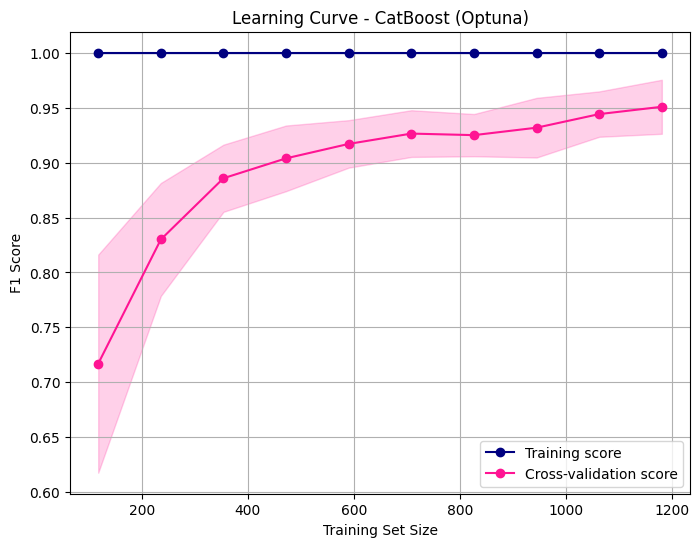

In [ ]:
# Learning Curve
# Ambil best model
best_model_row = all_results.loc[all_results["F1"].idxmax()]
best_model_obj = best_model_row["Model_Object"]

# Hitung learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model_obj,
    X=X_train_smote,
    y=y_train_smote,
    cv=10,
    scoring="f1",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42 if "random_state" in best_model_obj.get_params() else None
)

# Rata-rata dan standar deviasi
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="navy", label="Training score")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color="navy")

plt.plot(train_sizes, test_mean, 'o-', color="deeppink", label="Cross-validation score")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color="deeppink")

plt.title(f"Learning Curve - {best_model_row['Model']}")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.show()

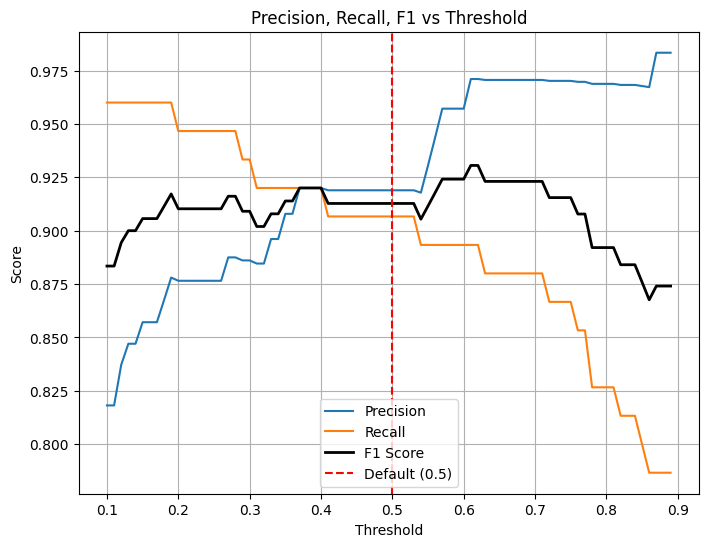

Threshold optimal (F1): 0.61
Precision: 0.9710, Recall: 0.8933, F1: 0.9306


In [ ]:
#threshold
y_proba = best_model["Model_Object"].predict_proba(X_test)[:, 1]

# Range threshold (0.1 - 0.9, step 0.01)
thresholds = np.arange(0.1, 0.9, 0.01)

precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1s.append(f1_score(y_test, y_pred))

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1 Score", linewidth=2, color="black")
plt.axvline(x=0.5, color="red", linestyle="--", label="Default (0.5)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Cari threshold terbaik untuk F1
best_idx = np.argmax(f1s)
print(f"Threshold optimal (F1): {thresholds[best_idx]:.2f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")

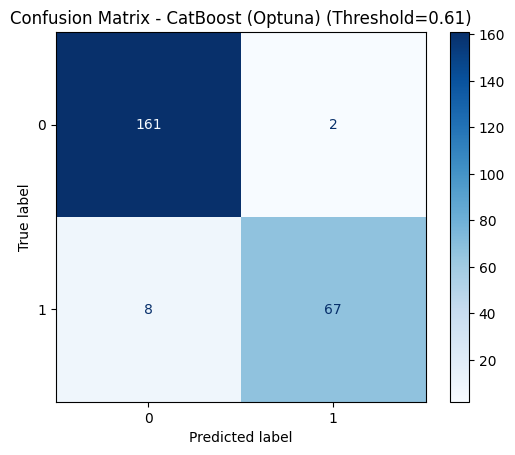


Evaluasi di Threshold 0.61:
Precision: 0.9710
Recall   : 0.8933
F1 Score : 0.9306


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Ambil model terbaik
best_model_row = all_results.loc[all_results["F1"].idxmax()]
best_model_obj = best_model_row["Model_Object"]

# Prediksi probabilitas
y_pred_proba = best_model_obj.predict_proba(X_test)[:, 1]

# Threshold optimal dari analisis
threshold_opt = 0.61
y_pred = (y_pred_proba >= threshold_opt).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_obj.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_row['Model']} (Threshold={threshold_opt})")
plt.show()

# Hitung metrik di threshold optimal
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nEvaluasi di Threshold {threshold_opt}:")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


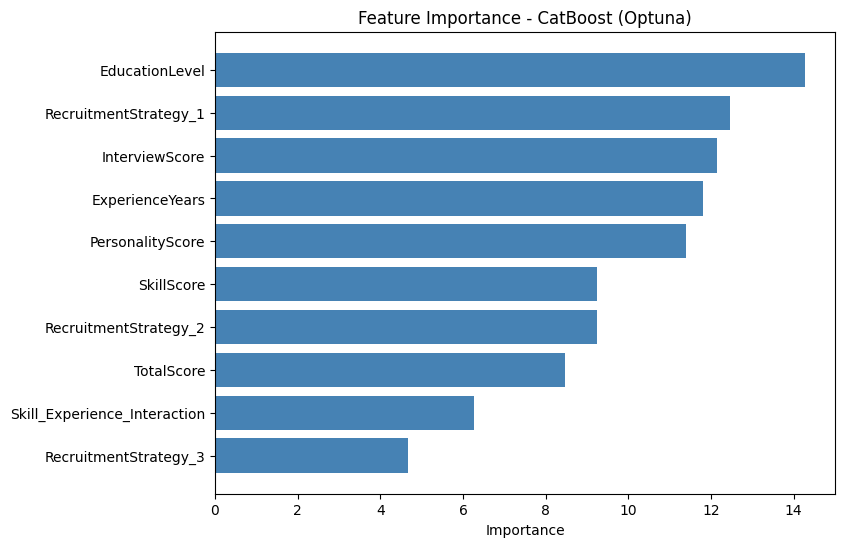

In [ ]:
# Feature Importance

if hasattr(best_model_obj, "coef_"):  # Linear model
    importance = np.mean(np.abs(best_model_obj.coef_), axis=0)
elif hasattr(best_model_obj, "feature_importances_"):  # Tree-based model
    importance = best_model_obj.feature_importances_
else:
    raise ValueError("Model tidak mendukung feature importance langsung.")

# Buat dataframe
feature_importance = pd.DataFrame({
    "Feature": X_train_smote.columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color="steelblue")
plt.gca().invert_yaxis()
plt.title(f"Feature Importance - {best_model_row['Model']}")
plt.xlabel("Importance")
plt.show()


In [ ]:
# Urutkan
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Tampilkan tabel
print(feature_importance)


                        Feature  Importance
0                EducationLevel   14.287274
5         RecruitmentStrategy_1   12.454821
2                InterviewScore   12.151518
1               ExperienceYears   11.801398
4              PersonalityScore   11.406872
3                    SkillScore    9.242374
6         RecruitmentStrategy_2    9.236666
7                    TotalScore    8.469125
8  Skill_Experience_Interaction    6.272749
9         RecruitmentStrategy_3    4.677203


#Explainable AI
untuk menjelaskan bagaimana model AI mengambil keputusan, supaya hasilnya bisa dimengerti, dipercaya, dan dipakai untuk perbaikan proses bisnis.
Penggunaan SHAP (SHapley Additive Explanations) dipilih karena lebih sesuai untuk model berbasis pohon seperti CatBoost, menghasilkan penjelasan yang konsisten, dan mampu memberikan interpretasi baik secara global maupun lokal. Dengan SHAP, prediksi model tidak hanya akurat tetapi juga lebih transparan dan mudah dipahami untuk mendukung pengambilan keputusan bisnis.

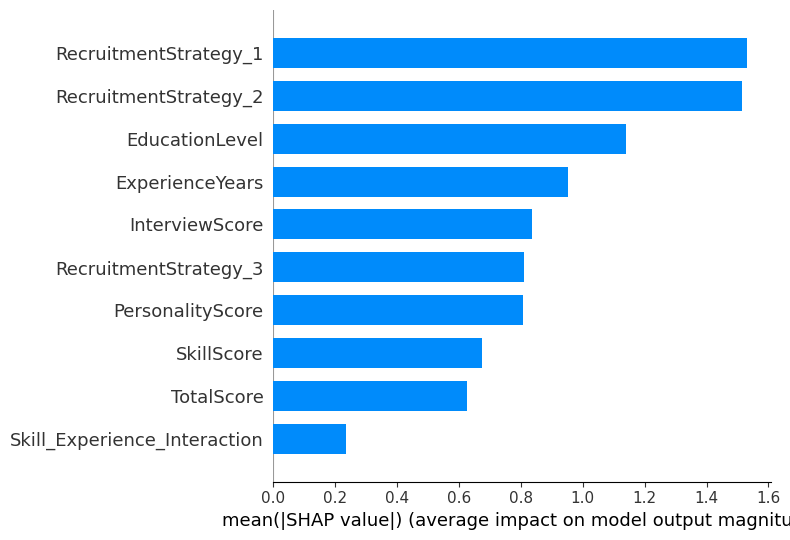

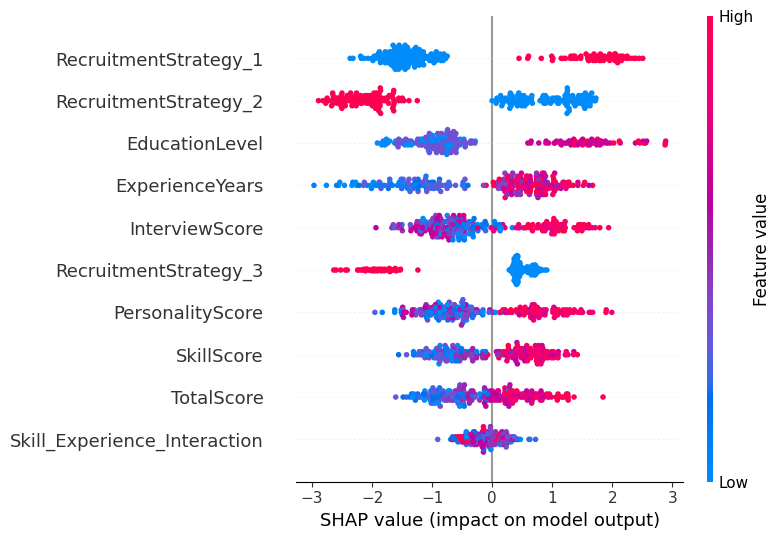

In [ ]:
import shap
import numpy as np

# Gunakan objek model CatBoost hasil tuning
best_model = best_model_obj

# Cek apakah tree-based
if hasattr(best_model, "predict_proba") and "CatBoost" in str(type(best_model)):
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # CatBoost binary → shap_values biasanya list [kelas_negatif, kelas_positif]
    if isinstance(shap_values, list):
        shap_values_to_plot = shap_values[1]  # ambil kelas positif (1)
    else:
        shap_values_to_plot = shap_values

else:
    explainer = shap.Explainer(best_model, X_test)
    shap_values = explainer(X_test)
    shap_values_to_plot = shap_values

# Summary bar plot
shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar")

# Detail distribusi per fitur
shap.summary_plot(shap_values_to_plot, X_test)

Hasil XAI SHAP menunjukkan bahwa faktor yang paling berpengaruh terhadap prediksi model adalah strategi rekrutmen, diikuti oleh tingkat pendidikan dan lama pengalaman kerja, sementara skor wawancara, kepribadian, serta skor teknis memiliki pengaruh yang lebih rendah. Hal ini mengindikasikan bahwa model lebih banyak mengandalkan faktor struktural seperti strategi, pendidikan, dan pengalaman dibandingkan faktor soft skill atau kombinasi antarvariabel, sehingga perusahaan dapat memfokuskan evaluasi pada strategi rekrutmen dan kualitas latar belakang kandidat untuk meningkatkan efektivitas seleksi.

# Bias & Fairness Assessment.
Untuk mengecek apakah model punya bias kinerja terhadap kelompok tertentu serta menjamin bahwa model tidak hanya akurat secara keseluruhan, tapi juga adil antar kelompok.

In [ ]:
# Ambil data asli dari data_normalized sesuai index X_test
fairness_df = data_normalized.loc[X_test.index, ["Gender", "Age", "EducationLevel", "RecruitmentStrategy"]].copy()

# Tambahkan kolom hasil prediksi dan label asli
fairness_df["y_true"] = y_test.values
fairness_df["y_pred"] = best_model.predict(X_test)

# Buat kategori usia (biar gak continuous)
fairness_df["AgeGroup"] = pd.cut(
    fairness_df["Age"], bins=[0, 29, 39, 100],
    labels=["<30", "30-39", "40+"]
)

# Fungsi fairness check
def fairness_check(df, group_col):
    results = {}
    for g, subset in df.groupby(group_col):
        report = classification_report(
            subset["y_true"], subset["y_pred"], output_dict=True, zero_division=0
        )
        results[g] = {
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1-score": report["weighted avg"]["f1-score"],
            "support": len(subset)
        }
    return pd.DataFrame(results).T

# Fairness Check untuk Gender
print("=== Gender ===")
print(fairness_check(fairness_df, "Gender"))

# Fairness Check untuk Age Group
print("\n=== Age Group ===")
print(fairness_check(fairness_df, "AgeGroup"))

# Fairness Check untuk Education Level
print("\n=== Education Level ===")
print(fairness_check(fairness_df, "EducationLevel"))

# Fairness Check untuk Recruitment Strategy
print("\n=== Recruitment Strategy ===")
print(fairness_check(fairness_df, "RecruitmentStrategy"))

=== Gender ===
   precision    recall  f1-score  support
0   0.944136  0.944444  0.944219    126.0
1   0.946429  0.946429  0.946429    112.0

=== Age Group ===
       precision    recall  f1-score  support
<30     0.921796  0.920354  0.919018    113.0
30-39        NaN       NaN       NaN      0.0
40+          NaN       NaN       NaN      0.0

=== Education Level ===
   precision    recall  f1-score  support
1   0.910235  0.912281  0.910856     57.0
2   0.947368  0.947368  0.947368    114.0
3   0.960000  0.960000  0.960000     50.0
4   1.000000  1.000000  1.000000     17.0

=== Recruitment Strategy ===
   precision    recall  f1-score  support
1   0.916667  0.916667  0.912151     72.0
2   0.954236  0.956522  0.953398    115.0
3   0.962527  0.960784  0.958429     51.0


/tmp/ipython-input-3261572443.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, subset in df.groupby(group_col):


Hasil fairness check menunjukkan bahwa model bekerja cukup konsisten pada sebagian besar kelompok, dengan F1-score relatif tinggi dan seimbang antara gender (0.94–0.95) serta antar strategi rekrutmen (0.93–0.94). Pada variabel tingkat pendidikan, meskipun mayoritas kelompok memiliki kinerja stabil (0.90–0.95), kelompok dengan level 4 justru mencapai F1-score sempurna karena jumlah datanya sangat sedikit (support = 17), sehingga hasil ini berpotensi bias. Sementara itu, pada variabel usia hanya kelompok <30 yang memiliki data cukup, sedangkan kelompok lain kosong sehingga fairness tidak dapat dievaluasi. Secara umum, model menunjukkan performa yang adil, namun distribusi data yang tidak merata (khususnya pada usia dan pendidikan level tinggi) perlu diperhatikan agar evaluasi fairness lebih representatif.

   Probabilitas_Diterima  Prediksi            Segmentasi  Aktual
0               0.003665         0  Low (Tidak Diterima)       0
1               0.014230         0  Low (Tidak Diterima)       1
2               0.996363         1       High (Diterima)       1
3               0.997912         1       High (Diterima)       1
4               0.005446         0  Low (Tidak Diterima)       0
5               0.001075         0  Low (Tidak Diterima)       0
6               0.005888         0  Low (Tidak Diterima)       0
7               0.004931         0  Low (Tidak Diterima)       0
8               0.009989         0  Low (Tidak Diterima)       0
9               0.000900         0  Low (Tidak Diterima)       0

Jumlah tiap segmentasi:
Segmentasi
Low (Tidak Diterima)     161
High (Diterima)           68
Medium (Pertimbangan)      9
Name: count, dtype: int64

Persentase tiap segmentasi:
Segmentasi
Low (Tidak Diterima)     67.647059
High (Diterima)          28.571429
Medium (Pertimbangan)     

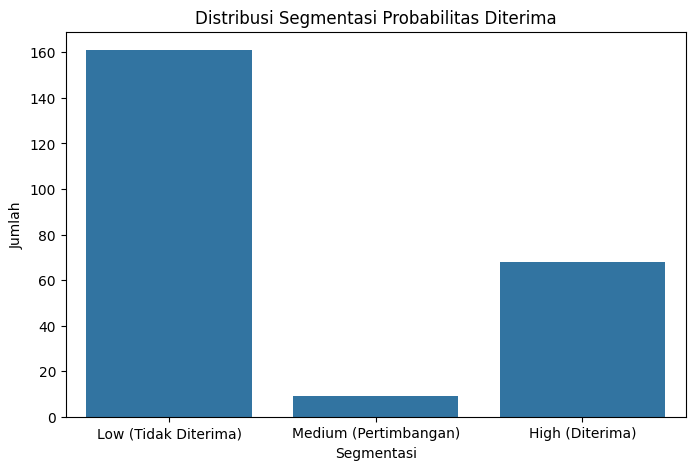

In [ ]:
# segmentasi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Probabilitas diterima (class 1)
y_prob = best_model_obj.predict_proba(X_test)[:, 1]

# Threshold optimal
threshold_opt = 0.61

# Prediksi berdasarkan threshold optimal
y_pred_threshold = (y_prob >= threshold_opt).astype(int)

# Segmentasi tambahan (Low, Medium, High)
def segmentasi(p):
    if p < 0.5:
        return "Low (Tidak Diterima)"
    elif p < threshold_opt:
        return "Medium (Pertimbangan)"
    else:
        return "High (Diterima)"

segments = pd.Series(y_prob).apply(segmentasi)

# Gabungkan hasil ke DataFrame
segmentasi_df = pd.DataFrame({
    "Probabilitas_Diterima": y_prob,
    "Prediksi": y_pred_threshold,
    "Segmentasi": segments,
    "Aktual": y_test.reset_index(drop=True)
})

# 1. Lihat 10 data pertama
print(segmentasi_df.head(10))

# 2. Hitung jumlah tiap segmentasi
jumlah_segment = segmentasi_df['Segmentasi'].value_counts()
print("\nJumlah tiap segmentasi:")
print(jumlah_segment)

# 3. Hitung persentase tiap segmentasi
persentase_segment = segmentasi_df['Segmentasi'].value_counts(normalize=True) * 100
print("\nPersentase tiap segmentasi:")
print(persentase_segment)

# 4. Plot visual (barplot)
plt.figure(figsize=(8,5))
sns.countplot(data=segmentasi_df, x='Segmentasi', order=["Low (Tidak Diterima)", "Medium (Pertimbangan)", "High (Diterima)"])
plt.title("Distribusi Segmentasi Probabilitas Diterima")
plt.ylabel("Jumlah")
plt.xlabel("Segmentasi")
plt.show()

# Business Impact

                  Cost       Time  Quality
Baseline    804.200000  29.700000  58.0000
With_Model  511.021614  18.872596  91.2752


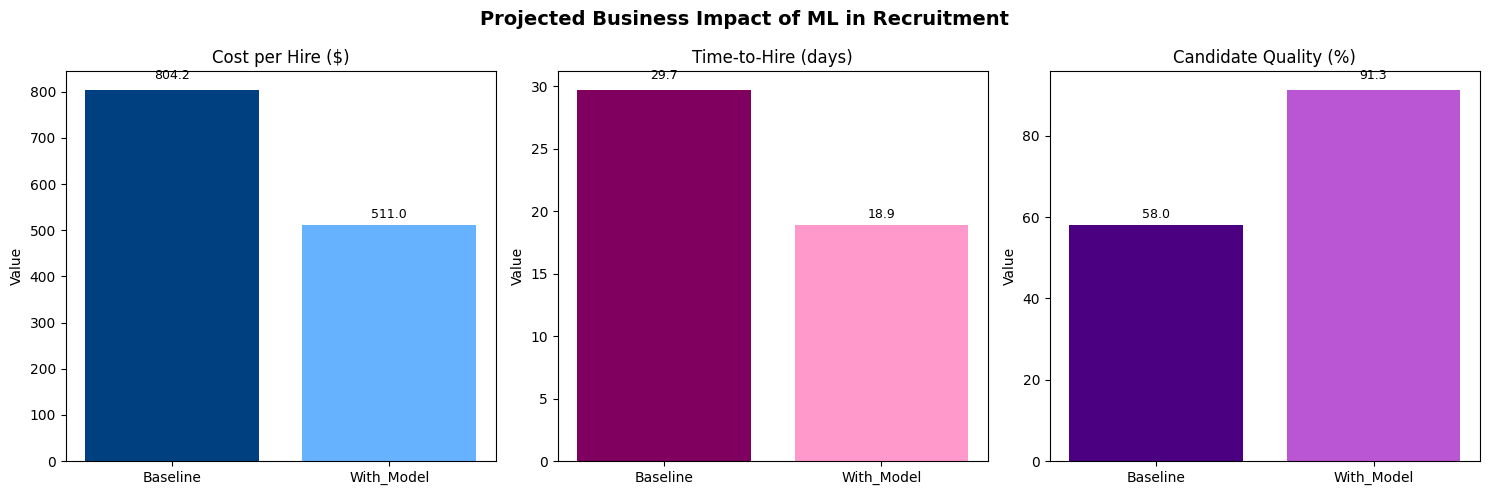

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Data awal (baseline) ---
baseline = {
    "Cost": 804.2,   # baseline cost ($)
    "Time": 29.7,      # baseline time (days)
    "Quality": 58.0  # baseline quality (%)
}

# --- F1 score hasil model ---
f1_score = 0.913

# --- Simulasi pakai rumus sederhana ---
simulated = {
    "Cost": baseline["Cost"] * (baseline["Quality"]/100) / f1_score,
    "Time": baseline["Time"] * (baseline["Quality"]/100) / f1_score,
    "Quality": f1_score * 100
}

# --- Buat DataFrame perbandingan ---
df = pd.DataFrame([baseline, simulated], index=["Baseline", "With_Model"])
print(df)

# --- Visualisasi dalam 3 subplot terpisah ---
fig, axes = plt.subplots(1, 3, figsize=(15,5))

metrics = ["Cost", "Time", "Quality"]
titles = ["Cost per Hire ($)", "Time-to-Hire (days)", "Candidate Quality (%)"]
colors = {
    "Cost": ("#004080", "#66b2ff"),    # biru tua & muda
    "Time": ("#800060", "#ff99cc"),    # ungu tua & muda (pink agak ke ungu)
    "Quality": ("#4B0082", "#BA55D3")  # ungu tua & muda
}

for ax, metric, title in zip(axes, metrics, titles):
    ax.bar(df.index, df[metric],
           color=[colors[metric][0], colors[metric][1]])
    for i, val in enumerate(df[metric]):
        ax.text(i, val+ (val*0.02), f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    ax.set_title(title)
    ax.set_ylabel("Value")

plt.suptitle("Projected Business Impact of ML in Recruitment", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


Penerapan machine learning dalam proses rekrutmen menunjukkan dampak positif yang signifikan. Biaya rekrutmen berhasil ditekan dari 804.2 dolar menjadi 511.0 dolar atau turun sekitar 36%. Waktu rekrutmen juga lebih efisien, berkurang dari 29.7 hari menjadi 18.9 hari, sehingga proses dapat berlangsung hampir 11 hari lebih cepat. Selain itu, kualitas kandidat yang diterima meningkat tajam dari 58% menjadi 91.3%. Hasil ini membuktikan bahwa penggunaan model machine learning mampu menjadikan proses rekrutmen lebih hemat biaya, lebih cepat, dan menghasilkan kandidat yang lebih sesuai dengan kebutuhan perusahaan.

# Rekomendasi Perbaikan Model

Karena keterbatasan jumlah data, pelatihan model sebaiknya dilakukan secara berkala per 6 bulan. Setelah jumlah data bertambah dapat dilakukan pembandingan ulang dengan model alternatif, termasuk neural network, yang terbukti memberikan hasil lebih baik.

# Deploy

# Best Model Catboost Optuna -> joblib

In [ ]:
def objective_cb(trial):
    iterations = trial.suggest_int("iterations", 100, 300)
    depth = trial.suggest_int("depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    l2_leaf_reg = trial.suggest_int("l2_leaf_reg", 1, 10)
    model = CatBoostClassifier(iterations=iterations,
                               depth=depth,
                               learning_rate=learning_rate,
                               l2_leaf_reg=l2_leaf_reg,
                               silent=True,
                               random_state=42)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    f1 = cross_val_score(model, X_train_smote, y_train_smote, scoring="f1", cv=cv, n_jobs=-1).mean()
    return f1

study_cb = optuna.create_study(direction="maximize")
study_cb.optimize(objective_cb, n_trials=20)

best_cb_optuna = CatBoostClassifier(**study_cb.best_params, silent=True, random_state=42)
best_cb_optuna.fit(X_train_smote, y_train_smote)

# Simpan model final dengan joblib
dump(best_cb_optuna, 'best_catboost_optuna.joblib')

[I 2025-09-17 15:49:37,880] A new study created in memory with name: no-name-b94a2133-49b3-4073-a7e0-2406784d6cfb
[I 2025-09-17 15:50:46,548] Trial 0 finished with value: 0.9465531138126752 and parameters: {'iterations': 291, 'depth': 10, 'learning_rate': 0.21631959787044408, 'l2_leaf_reg': 3}. Best is trial 0 with value: 0.9465531138126752.
[I 2025-09-17 15:51:20,777] Trial 1 finished with value: 0.9445483164620129 and parameters: {'iterations': 231, 'depth': 9, 'learning_rate': 0.18877716168991704, 'l2_leaf_reg': 6}. Best is trial 0 with value: 0.9465531138126752.
[I 2025-09-17 15:51:21,842] Trial 2 finished with value: 0.9237971963904039 and parameters: {'iterations': 100, 'depth': 3, 'learning_rate': 0.21138094337570115, 'l2_leaf_reg': 1}. Best is trial 0 with value: 0.9465531138126752.
[I 2025-09-17 15:51:24,597] Trial 3 finished with value: 0.917542129748892 and parameters: {'iterations': 224, 'depth': 2, 'learning_rate': 0.25173485136819124, 'l2_leaf_reg': 10}. Best is trial 0 w

['best_catboost_optuna.joblib']

# Standard Scaler -> joblib

In [ ]:
# Asumsikan data_bersih sudah ada (dari notebook Anda)
# Jika belum, pastikan Anda memuat data terlebih dahulu
df = pd.read_csv('recruitment_data.csv')

# Definisikan kolom numerik
numeric_columns = [
                    # 'Age'
                    'ExperienceYears'
                #    , 'PreviousCompanies'
                   , 'InterviewScore'
                   , 'SkillScore'
                   , 'PersonalityScore'
                #    , 'DistanceFromCompany'
                   ]

# Identifikasi dan hapus anomali (seperti di notebook)
anomali1 = df[df["ExperienceYears"] > (df["Age"] - 17)]
anomali2 = df[(df["ExperienceYears"] == 0) & (df["PreviousCompanies"] > 2)]
anomali = pd.concat([anomali1, anomali2])
data_bersih = df.drop(anomali.index)
data_bersih2 = df.drop(['Age', 'PreviousCompanies', 'DistanceFromCompany'], axis=1)

# Inisialisasi dan terapkan StandardScaler
scaler = StandardScaler()
data_normalized = data_bersih2.copy()
data_normalized[numeric_columns] = scaler.fit_transform(data_bersih2[numeric_columns])

# Simpan scaler ke file
dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [ ]:
from google.colab import files
files.download("best_catboost_optuna.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("scaler.joblib")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Streamlit

In [ ]:
import os
import joblib
import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px

# ===================== Page Config =====================
st.set_page_config(page_title="Recruitment Prediction App", layout="wide")
ACCENT_COLOR = "#1F3A93"

# ===================== Load Font Awesome =====================
st.markdown("""
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/6.4.0/css/all.min.css">
""", unsafe_allow_html=True)

# ===================== CSS Custom =====================
st.markdown("""
<style>
.topbar {
    display: flex;
    justify-content: space-between;
    align-items: center;
    padding: 10px 25px;
    background: linear-gradient(to right, #2b1e77, #6a0dad);
    color: white;
    font-weight: bold;
    font-size: 30px;
    border-radius: 12px;
}
.topbar .icon { font-size: 30px; color: white; }
.hero-title {
    text-align: center;
    font-size: 40px;
    font-weight: bold;
    color: white;
    background: linear-gradient(to right, #2b1e77, #6a0dad);
    padding: 20px;
    border-radius: 18px;
    margin: 15px auto;
    width: 85%;
}
.hero-title i { margin-right: 10px; }
.instruction-box {
    background: #D8E6F4;
    color: #000;
    padding: 15px;
    border-radius: 12px;
    font-size: 16px;
    margin: 10px 0;
}
.stButton>button {
    background: linear-gradient(to right, #6a0dad, #2b1e77);
    color: white;
    font-weight: 900;
    border-radius: 25px;
    padding: 10px 24px;
    border: none;
    font-size: 20px;
    cursor: pointer;
    width: 100%;
}
.stButton>button:hover { opacity: 0.9; }
.tbl-header { font-weight:bold; text-align:center; border:1px solid #ccc; padding:8px; background:#E6E6FA;}
.tbl-cell { border:1px solid #ccc; padding:6px; text-align:center; font-size:16px; }
.status-accepted { background-color: #D8F4D7; color:green; font-weight:bold; }
.status-rejected { background-color: #FADBD8; color:red; font-weight:bold; }
[data-baseweb="radio"] label {
    color: white !important;
    font-weight: bold !important;
}
</style>
""", unsafe_allow_html=True)

# ===================== Topbar & Hero =====================
st.markdown("""
<div class="topbar">
    <div>PANCARONA</div>
    <div class="icon"><i class="fas fa-briefcase"></i></div>
</div>
""", unsafe_allow_html=True)

st.markdown("""
<div class="hero-title">
    <i class="fas fa-user"></i> Recruitment Prediction App
</div>
""", unsafe_allow_html=True)

# ===================== Sidebar =====================
st.sidebar.markdown("""
<div style="
    display:flex;
    flex-direction:column;
    align-items:center;
    justify-content:center;
    text-align:center;
    padding: 20px;
    border-radius: 12px;
    background: linear-gradient(to bottom, #2b1e77, #6a0dad);
    color: white;
">
    <h3 style='font-weight:bold; margin-bottom:15px;'>Recruitment Prediction</h3>
    <div style='background: #FFFFFF;
                color: #000;
                padding: 15px;
                border-radius: 12px;
                font-size: 16px;
                margin-top: 10px;
                width: 90%;
                text-align:center;'>
        Aplikasi ini membantu proses rekrutmen agar lebih efisien dan objektif.
    </div>
    <div style='background: #FFFFFF;
                color: #000;
                padding: 15px;
                border-radius: 12px;
                font-size: 16px;
                margin-top: 10px;
                width: 90%;
                text-align:center;'>
        Fokus utamanya adalah mendukung tahap akhir seleksi dengan memanfaatkan data penilaian kandidat untuk keputusan penerimaan yang lebih tepat.
    </div>
</div>

<div style="margin-top: 20px;">
    <p style='color:black; font-weight:bold; margin-bottom:5px;'>Pilih Halaman</p>
</div>
""", unsafe_allow_html=True)

# Radio button halaman
page_options = ["Input Data", "Prediksi", "EDA"]
page = st.sidebar.radio("", page_options, label_visibility="collapsed")

# ===================== Load Model & Scaler =====================
model, scaler = None, None
if os.path.exists("best_catboost_optuna.joblib") and os.path.exists("scaler.joblib"):
    model = joblib.load("best_catboost_optuna.joblib")
    scaler = joblib.load("scaler.joblib")
else:
    st.warning("⚠ File model atau scaler tidak ditemukan. Prediksi tidak bisa dijalankan.")

# ===================== Preprocess =====================
def preprocess_input(df, scaler):
    numeric_cols = ['ExperienceYears','InterviewScore','SkillScore','PersonalityScore']
    df['TotalScore'] = df['SkillScore'] + df['InterviewScore'] + df['PersonalityScore']
    df['Skill_Experience_Interaction'] = df['SkillScore'] * df['ExperienceYears']

    # One-hot recruitment
    rec_map = {1:[1,0,0], 2:[0,1,0], 3:[0,0,1]}
    rec_cols = ['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3']
    df[rec_cols] = df['RecruitmentStrategy'].map(lambda x: rec_map.get(x,[0,0,0])).apply(pd.Series)

    # Normalisasi numeric tetap di balik layar
    df[numeric_cols] = scaler.transform(df[numeric_cols])

    selected_features = ['EducationLevel','ExperienceYears','InterviewScore','SkillScore','PersonalityScore',
                         'TotalScore','RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3',
                         'Skill_Experience_Interaction']
    return df[selected_features]

# ===================== Halaman Input Data =====================
if page == "Input Data":
    st.markdown("<h2 style='text-align:center; background:linear-gradient(to right,#2b1e77,#6a0dad); color:white; padding:12px; border-radius:12px;'><i class='fas fa-file-upload'></i> Input Data Kandidat</h2>", unsafe_allow_html=True)

    st.markdown("""
    <div class="instruction-box">
    Threshold diterima  : 61% <br>
    Model               : Catboost Optuna  <br>
    F1-Score            : 0.913
    </div>
    """, unsafe_allow_html=True)

    st.markdown("""
    <div class="instruction-box">
    File CSV harus berisi kolom:<br>
    - Name<br>
    - EducationLevel<br>
    - ExperienceYears<br>
    - InterviewScore<br>
    - SkillScore<br>
    - PersonalityScore<br>
    - RecruitmentStrategy
    </div>
    """, unsafe_allow_html=True)

    uploaded_file = st.file_uploader("Upload File CSV", type=['csv'])
    if uploaded_file:
        df_input = pd.read_csv(uploaded_file)
        st.session_state.df_input = df_input
        st.info(f"Total data: {len(df_input)} baris")
        st.dataframe(df_input.head(10))

        if st.button("Prediksi"):
            if model and scaler:
                df_pred = df_input.copy()
                processed = preprocess_input(df_pred, scaler)
                processed = processed[['EducationLevel','ExperienceYears','InterviewScore','SkillScore','PersonalityScore',
                                       'TotalScore','RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3',
                                       'Skill_Experience_Interaction']]
                prob = model.predict_proba(processed)[:,1]*100
                df_pred['Probability'] = prob
                df_pred['Status'] = np.where(prob>=61,"Diterima","Tidak Diterima")
                st.session_state.pred_df = df_pred
                st.success("Prediksi selesai. Lihat halaman 'Prediksi'.")

# ===================== Halaman Prediksi =====================
elif page == "Prediksi":
    st.markdown("<h2 style='text-align:center; background:linear-gradient(to right,#2b1e77,#6a0dad); color:white; padding:12px; border-radius:12px; margin-bottom:15px;'><i class='fas fa-chart-line'></i> Hasil Prediksi</h2>", unsafe_allow_html=True)

    if "pred_df" in st.session_state:
        df_pred = st.session_state.pred_df
        preview_df = df_pred.head(15).copy()
        preview_df_display = preview_df.drop(columns=['RecruitmentStrategy_1','RecruitmentStrategy_2','RecruitmentStrategy_3','Skill_Experience_Interaction'])
        preview_df_display['Status'] = preview_df_display['Status'].apply(
            lambda x: f"<span style='color:green;font-weight:bold;'>{x}</span>" if x=="Diterima"
                      else f"<span style='color:red;font-weight:bold;'>{x}</span>"
        )
        st.markdown(preview_df_display.to_html(escape=False, index=False), unsafe_allow_html=True)

        csv = df_pred.to_csv(index=False).encode('utf-8')
        st.download_button("⬇ Download Hasil Prediksi", data=csv, file_name="hasil_prediksi.csv", mime="text/csv")

        top10 = df_pred.sort_values(by="Probability", ascending=False).head(10).copy()
        top10_display = top10[['Name','EducationLevel','ExperienceYears','RecruitmentStrategy','TotalScore','Probability','Status']]
        top10_display['Status'] = top10_display['Status'].apply(
            lambda x: f"<span style='color:green;font-weight:bold;'>{x}</span>" if x=="Diterima"
                      else f"<span style='color:red;font-weight:bold;'>{x}</span>"
        )
        st.markdown("<h3 style='margin-top:20px;'>Top 10 Kandidat Berdasarkan Probability</h3>", unsafe_allow_html=True)
        st.markdown(top10_display.to_html(escape=False, index=False), unsafe_allow_html=True)

    else:
        st.info("⚠ Belum ada data prediksi. Silakan lakukan upload dan prediksi di halaman Input Data.")

# ===================== Halaman EDA =====================
elif page == "EDA":
    st.markdown("<h2 style='text-align:center; background:linear-gradient(to right,#2b1e77,#6a0dad); color:white; padding:12px; border-radius:12px;'><i class='fas fa-chart-pie'></i> Exploratory Data Analysis</h2>", unsafe_allow_html=True)

    if "pred_df" in st.session_state and "df_input" in st.session_state:
        df_eda_pred = st.session_state.pred_df.copy()
        df_eda_orig = st.session_state.df_input.copy()
        df_eda_orig['Probability'] = df_eda_pred['Probability']
        df_eda_orig['Status'] = df_eda_pred['Status']

        # Pie Charts
        status_counts = df_eda_orig['Status'].value_counts().reset_index()
        status_counts.columns = ['Status','Count']
        fig_status = px.pie(status_counts, names='Status', values='Count',
                            color='Status',
                            color_discrete_map={'Diterima':'#4682B4','Tidak Diterima':'#89CFF0'},
                            title='Distribusi Status Kandidat')
        st.plotly_chart(fig_status)

        rec_counts = df_eda_orig['RecruitmentStrategy'].map({1:'Referral',2:'Job Fair',3:'Outsourcing'}).value_counts().reset_index()
        rec_counts.columns = ['RecruitmentStrategy','Count']
        fig_rec = px.pie(rec_counts, names='RecruitmentStrategy', values='Count',
                         color_discrete_sequence=["#336289",'#4682B4','#89CFF0'],
                         title='Distribusi Recruitment Strategy')
        st.plotly_chart(fig_rec)

        edu_counts = df_eda_orig['EducationLevel'].map({1:'High School',2:'Bachelor',3:'Master',4:'PhD'}).value_counts().reset_index()
        edu_counts.columns = ['EducationLevel','Count']
        fig_edu = px.pie(edu_counts, names='EducationLevel', values='Count',
                         color_discrete_sequence=["#284F6E", "#336289",'#4682B4','#89CFF0'],
                         title='Distribusi Education Level')
        st.plotly_chart(fig_edu)

        # Histogram numeric asli
        numeric_cols = ['ExperienceYears','InterviewScore','SkillScore','PersonalityScore']
        df_eda_orig['TotalScore'] = df_eda_orig['SkillScore'] + df_eda_orig['InterviewScore'] + df_eda_orig['PersonalityScore']
        numeric_cols.append('TotalScore')
        for col in numeric_cols:
            fig_bar = px.histogram(df_eda_orig, x=col, color_discrete_sequence=['#4682B4'], title=f'Distribusi {col}')
            st.plotly_chart(fig_bar)

    else:
        st.info("⚠ Belum ada data untuk EDA. Silakan lakukan prediksi terlebih dahulu di halaman Input Data.")

# Ekstrak CV

In [ ]:
import streamlit as st
import PyPDF2
import pytesseract
from pdf2image import convert_from_bytes
import re
from PIL import Image
import io

# Fungsi untuk mengekstrak teks dari PDF (teks atau gambar)
def extract_text_from_pdf(pdf_file):
    try:
        # Coba ekstrak teks langsung menggunakan PyPDF2
        reader = PyPDF2.PdfReader(pdf_file)
        text = ""
        for page in reader.pages:
            extracted = page.extract_text()
            if extracted:
                text += extracted
        if text.strip():  # Jika teks berhasil diekstrak
            return text

        # Jika teks tidak bisa diekstrak (PDF berbasis gambar), gunakan OCR
        pdf_file.seek(0)  # Reset posisi file
        images = convert_from_bytes(pdf_file.read())
        text = ""
        for image in images:
            text += pytesseract.image_to_string(image, lang='ind')  # Gunakan bahasa Indonesia untuk OCR
        return text
    except Exception as e:
        return f"Error extracting text: {str(e)}"

# Fungsi untuk mengekstrak informasi dari teks
def extract_info(text):
    # Ekstrak nama
    name_pattern = r"(?:Nama|Name|Identitas)[:\s]*(.*?)(?:\n|$)"
    name_match = re.search(name_pattern, text, re.IGNORECASE)
    name = name_match.group(1).strip() if name_match else None

    # Ekstrak email
    email_pattern = r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}'
    email = re.findall(email_pattern, text)
    email = email[0] if email else None

    # Ekstrak nomor telepon (format fleksibel)
    phone_pattern = r'(?:\+62|08)[\s.-]?\d{2,4}[\s.-]?\d{3,4}[\s.-]?\d{3,5}'
    phone = re.findall(phone_pattern, text)
    phone = phone[0] if phone else None

    # Ekstrak usia
    age_pattern = r"(?:Usia|Umur|Age|Tahun lahir|Tanggal lahir)[:\s]*(\d{1,2})\s*(?:tahun)?"
    age_match = re.search(age_pattern, text, re.IGNORECASE)
    age = age_match.group(1) if age_match else None
    if not age:
        birth_year_pattern = r"(?:Tahun lahir|Tanggal lahir)[:\s]*(\d{4})"
        birth_year_match = re.search(birth_year_pattern, text, re.IGNORECASE)
        if birth_year_match:
            current_year = 2025
            age = current_year - int(birth_year_match.group(1))

    # Ekstrak pendidikan
    education_keywords = ["pendidikan", "riwayat pendidikan", "edukasi", "sekolah", "universitas", "s1", "s2", "sma", "smk"]
    education = []
    lines = text.split('\n')
    for i, line in enumerate(lines):
        if any(keyword.lower() in line.lower() for keyword in education_keywords):
            edu_lines = lines[i:i+5]  # Ambil 5 baris berikutnya untuk konteks
            edu_text = " ".join([l.strip() for l in edu_lines if l.strip()])

            # Ekstraksi nama sekolah/universitas
            school_pattern = r"(Universitas\s+[A-Za-z ]+|Institut\s+[A-Za-z ]+|Sekolah Tinggi\s+[A-Za-z ]+|SMA\s+[A-Za-z ]+|SMK\s+[A-Za-z ]+)"
            school_match = re.findall(school_pattern, edu_text, re.IGNORECASE)
            school = school_match[0].strip() if school_match else None

            # Ekstraksi jurusan
            major_pattern = r"(Jurusan\s*[:\-]?\s*[A-Za-z ]+|Prodi\s*[:\-]?\s*[A-Za-z ]+)"
            major_match = re.findall(major_pattern, edu_text, re.IGNORECASE)
            major = major_match[0].strip() if major_match else None

            # Ekstraksi IPK atau nilai rata-rata
            grade_pattern = r"(IPK|Nilai Rata-rata|Nilai Akhir)\s*[:\-]?\s*(\d\.\d{1,2})"
            grade_match = re.findall(grade_pattern, edu_text, re.IGNORECASE)
            grade = f"{grade_match[0][0]}: {grade_match[0][1]}" if grade_match else None

            # Ekstraksi tahun kelulusan
            year_pattern = r"(20\d{2}|19\d{2})"
            year_match = re.findall(year_pattern, edu_text)
            year = year_match[0] if year_match else None

            if any([school, major, grade, year]):  # Hanya tambahkan jika ada informasi yang valid
                education.append({
                    "school": school,
                    "major": major,
                    "grade": grade,
                    "year": year
                })

    # Ekstrak pengalaman kerja
    experience_keywords = ["pengalaman kerja", "riwayat pekerjaan", "pekerjaan", "pengalaman", "jabatan"]
    experience = []
    for i, line in enumerate(lines):
        if any(keyword.lower() in line.lower() for keyword in experience_keywords):
            exp_lines = lines[i:i+5]
            experience.append(" ".join([l for l in exp_lines if l.strip()]))

    return {
        "name": name,
        "email": email,
        "phone": phone,
        "age": age,
        "education": education if education else None,
        "experience": experience if experience else None
    }

# Aplikasi Streamlit
st.title("Ekstrak Informasi CV (Bahasa Indonesia)")
st.write("Unggah satu atau lebih file CV dalam format PDF untuk mengekstrak informasi seperti nama, email, nomor telepon, usia, pendidikan, dan pengalaman kerja.")

# Unggah multiple file PDF
uploaded_files = st.file_uploader("Pilih file CV (PDF)", type=["pdf"], accept_multiple_files=True)

if uploaded_files:
    for idx, uploaded_file in enumerate(uploaded_files):
        st.subheader(f"Hasil Ekstraksi CV {idx + 1}: {uploaded_file.name}")

        # Ekstrak teks dari PDF
        text = extract_text_from_pdf(uploaded_file)

        # Ekstrak informasi
        info = extract_info(text)

        # Tampilkan hasil
        st.write(f"**Nama**: {info['name'] if info['name'] else 'Tidak ditemukan'}")
        st.write(f"**Email**: {info['email'] if info['email'] else 'Tidak ditemukan'}")
        st.write(f"**Nomor Telepon**: {info['phone'] if info['phone'] else 'Tidak ditemukan'}")
        st.write(f"**Usia**: {info['age'] if info['age'] else 'Tidak ditemukan'}")

        # Tampilkan pendidikan
        st.write("**Pendidikan**:")
        if info['education']:
            for edu in info['education']:
                edu_display = []
                if edu.get('school'):
                    edu_display.append(f"Nama Sekolah/Universitas: {edu['school']}")
                if edu.get('major'):
                    edu_display.append(f"Jurusan: {edu['major']}")
                if edu.get('grade'):
                    edu_display.append(f"IPK/Nilai Rata-rata: {edu['grade']}")
                if edu.get('year'):
                    edu_display.append(f"Tahun Lulus: {edu['year']}")

                if edu_display:
                    st.write(f"- {', '.join(edu_display)}")
                else:
                    st.write("- Informasi pendidikan tidak lengkap")
        else:
            st.write("- Tidak ditemukan")

        # Tampilkan pengalaman kerja
        st.write("**Pengalaman Kerja**:")
        if info['experience']:
            for exp in info['experience']:
                st.write(f"- {exp}")
        else:
            st.write("- Tidak ditemukan")
        st.markdown("---")